<a href="https://colab.research.google.com/github/paolaCaushi/anomalyDetectionWithTransferLearning/blob/prapMeVAE-TL/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***VAE FOR ANOMALY DETECTION***

Number of rows (including header): 2670
Number of columns: 9

Sample of the data (first 5 rows):
   idAnomalia idConcentratore        dataAnomalia latitudine longitudine  \
0    18526375        SR013287 2023-05-26 12:16:28    39,2512      9,1338   
1    18699686        SR013287 2023-01-11 13:46:47    39,2585      9,0723   
2    19367851        SR013279 2022-10-10 08:42:46     40,124     18,3356   
3    21068660        SR013279 2022-03-26 07:52:15    41,2507     16,2203   
4    21076623        SR010385 2022-03-28 06:58:52    44,2287     12,0657   

       dataCoordinate        dataSegnalazione note  idPunto  Target  
0 2023-05-26 12:16:28 2015-04-22 14:24:01.353  NaN      NaN       0  
1 2023-01-11 13:46:47 2015-06-27 09:05:07.203  NaN  45267.0       0  
2 2022-10-10 08:42:46 2015-10-12 09:07:23.653  NaN  42607.0       0  
3 2022-03-26 07:52:15 2016-04-16 09:01:19.923  NaN  40981.0       0  
4 2022-03-28 06:58:52 2016-04-18 07:13:12.357  NaN      NaN       0  

Distribution of target va

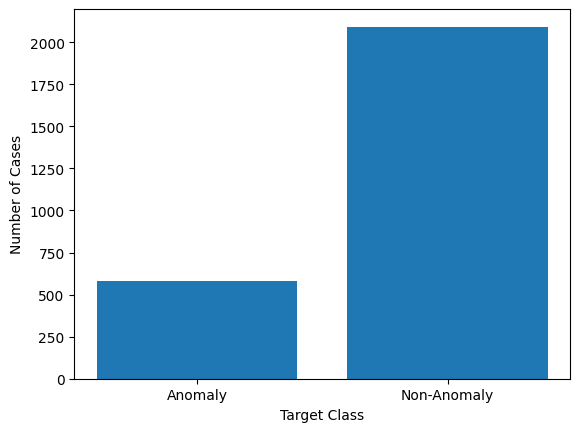

Epoch 1/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - loss: 0.6251 - val_loss: 0.2348
Epoch 2/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.1370 - val_loss: 0.0236
Epoch 3/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0175 - val_loss: 0.0107
Epoch 4/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0099 - val_loss: 0.0083
Epoch 5/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0076 - val_loss: 0.0075
Epoch 6/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0070 - val_loss: 0.0072
Epoch 7/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0066 - val_loss: 0.0072
Epoch 8/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0069 - val_loss: 0.0069
Epoch 9/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0066 - val_loss: 0.0070
Epoch 10/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0062 - val_loss: 0.0070
Epoch 11/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0062 - val_loss: 0.0069
Epoch 12/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step

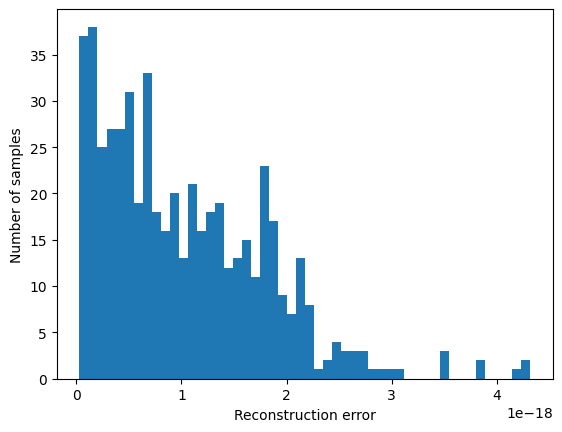

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras import layers, models, losses

# Specify the path to the Excel file
data_file = "Anomalies_2021_2024.xlsx"

# Read data from Excel into a DataFrame
df = pd.read_excel(data_file, sheet_name="Sheet1", header=0)

# Print basic information about the data
print(f"Number of rows (including header): {df.shape[0]}")
print(f"Number of columns: {df.shape[1]}")

# Create target variable based on 'idPunto' being null and 'note' being 12 or 6
df['Target'] = df.apply(lambda row: 1 if pd.isnull(row['idPunto']) and row['note'] in [12, 6] else 0, axis=1)

# Print a sample of the data (first 5 rows)
print("\nSample of the data (first 5 rows):")
print(df.head())

# Print the distribution of the target variable
anomaly_count = df['Target'].sum()
non_anomaly_count = df.shape[0] - anomaly_count
print(f"\nDistribution of target variable:")
print(f"--- Anomaly cases (idPunto NULL and note 12 or 6): {anomaly_count}")
print(f"--- Non-Anomaly cases: {non_anomaly_count}")

# Visualize the distribution with a bar chart
plt.bar(["Anomaly", "Non-Anomaly"], [anomaly_count, non_anomaly_count])
plt.xlabel("Target Class")
plt.ylabel("Number of Cases")
plt.show()

# Drop the 'idPunto' and 'note' columns and convert datetime columns
df = df.drop(columns=['idPunto', 'note'])

# Convert datetime columns to numeric
datetime_columns = ['dataAnomalia', 'dataCoordinate', 'dataSegnalazione']
for col in datetime_columns:
    df[col] = pd.to_datetime(df[col], errors='coerce').astype('int64') // 10**9

# Fill NaN values in datetime columns with median
for col in datetime_columns:
    df[col].fillna(df[col].median(), inplace=True)

# Convert categorical columns to string type
categorical_features = df.select_dtypes(include=['object']).columns
df[categorical_features] = df[categorical_features].astype(str)

# Separate features and target variable
X = df.drop(columns=['Target'])
y = df['Target']

# Identify numeric and categorical features
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Define preprocessing pipelines for numeric and categorical data
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combine preprocessing pipelines into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Apply preprocessing to the features
X_preprocessed = preprocessor.fit_transform(X)

# Convert the sparse matrix to a dense array
X_preprocessed = X_preprocessed.toarray()

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)

# Define the VAE model
def build_vae(input_shape, latent_dim):
    inputs = layers.Input(shape=(input_shape,))

    # Encoder
    x = layers.Dense(64, activation='relu')(inputs)
    x = layers.Dense(32, activation='relu')(x)
    z_mean = layers.Dense(latent_dim)(x)
    z_log_var = layers.Dense(latent_dim)(x)

    def sampling(args):
        z_mean, z_log_var = args
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

    z = layers.Lambda(sampling)([z_mean, z_log_var])

    # Decoder
    decoder_inputs = layers.Input(shape=(latent_dim,))
    x = layers.Dense(32, activation='relu')(decoder_inputs)
    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(input_shape, activation='sigmoid')(x)

    encoder = models.Model(inputs, [z_mean, z_log_var, z])
    decoder = models.Model(decoder_inputs, outputs)

    vae_outputs = decoder(encoder(inputs)[2])
    vae = models.Model(inputs, vae_outputs)

    # Custom loss layer for reconstruction loss
    class CustomVariationalLayer(layers.Layer):
        def vae_loss(self, x, z_mean, z_log_var, x_decoded_mean):
            xent_loss = tf.keras.losses.binary_crossentropy(x, x_decoded_mean)
            kl_loss = - 0.5 * tf.reduce_sum(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1, axis=-1)
            return tf.reduce_mean(xent_loss + kl_loss)

        def call(self, inputs):
            x = inputs[0]
            z_mean = inputs[1]
            z_log_var = inputs[2]
            x_decoded_mean = inputs[3]
            loss = self.vae_loss(x, z_mean, z_log_var, x_decoded_mean)
            self.add_loss(loss)
            return x

    custom_layer = CustomVariationalLayer()([inputs, z_mean, z_log_var, vae_outputs])

    vae = models.Model(inputs, custom_layer)
    vae.compile(optimizer='adam')

    return vae, encoder, decoder

# Build the VAE model
input_shape = X_train.shape[1]
latent_dim = 2  # Example latent dimension
vae, encoder, decoder = build_vae(input_shape, latent_dim)

# Train the VAE
history = vae.fit(X_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1)

# Predict on the test set
X_test_pred = vae.predict(X_test)

# Calculate reconstruction error
reconstruction_loss = np.mean(np.square(X_test - X_test_pred), axis=1)

# Define a threshold for anomaly detection
threshold = np.percentile(reconstruction_loss, 90)  # 90th percentile can be considered as the threshold

# Identify anomalies
y_pred = (reconstruction_loss > threshold).astype(int)

# Print the classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Visualize the reconstruction error
plt.hist(reconstruction_loss, bins=50)
plt.xlabel("Reconstruction error")
plt.ylabel("Number of samples")
plt.show()

# **Me SMOTE**

Number of rows (including header): 2670
Number of columns: 9

Sample of the data (first 5 rows):
   idAnomalia idConcentratore        dataAnomalia latitudine longitudine  \
0    18526375        SR013287 2023-05-26 12:16:28    39,2512      9,1338   
1    18699686        SR013287 2023-01-11 13:46:47    39,2585      9,0723   
2    19367851        SR013279 2022-10-10 08:42:46     40,124     18,3356   
3    21068660        SR013279 2022-03-26 07:52:15    41,2507     16,2203   
4    21076623        SR010385 2022-03-28 06:58:52    44,2287     12,0657   

       dataCoordinate        dataSegnalazione note  idPunto  Target  
0 2023-05-26 12:16:28 2015-04-22 14:24:01.353  NaN      NaN       0  
1 2023-01-11 13:46:47 2015-06-27 09:05:07.203  NaN  45267.0       0  
2 2022-10-10 08:42:46 2015-10-12 09:07:23.653  NaN  42607.0       0  
3 2022-03-26 07:52:15 2016-04-16 09:01:19.923  NaN  40981.0       0  
4 2022-03-28 06:58:52 2016-04-18 07:13:12.357  NaN      NaN       0  

Distribution of target va

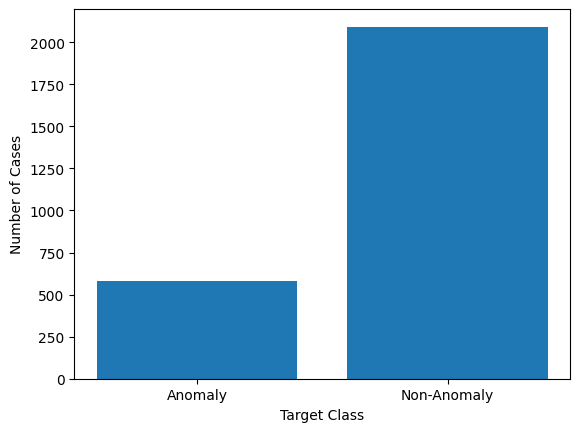

Epoch 1/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.6319 - val_loss: 0.2418
Epoch 2/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1319 - val_loss: 0.0241
Epoch 3/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0177 - val_loss: 0.0107
Epoch 4/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0099 - val_loss: 0.0084
Epoch 5/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0077 - val_loss: 0.0076
Epoch 6/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0070 - val_loss: 0.0072
Epoch 7/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0072 - val_loss: 0.0074
Epoch 8/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0068 - val_loss: 0.0072
Epoch 9/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0065 - val_loss: 0.0071
Epoch 10/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0062 - val_loss: 0.0074
Epoch 11/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0063 - val_loss: 0.0072
Epoch 12/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step

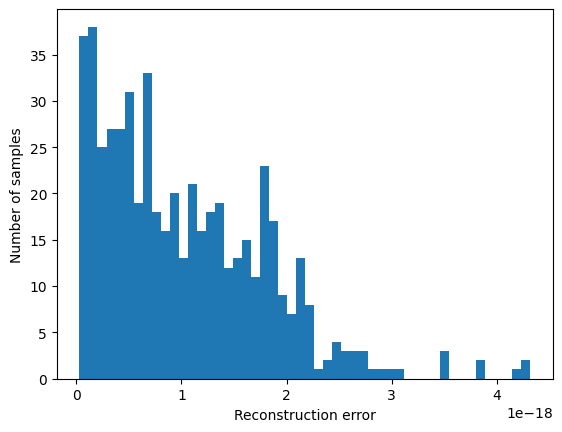

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras import layers, models, losses

# Specify the path to the Excel file
data_file = "Anomalies_2021_2024.xlsx"

# Read data from Excel into a DataFrame
df = pd.read_excel(data_file, sheet_name="Sheet1", header=0)

# Print basic information about the data
print(f"Number of rows (including header): {df.shape[0]}")
print(f"Number of columns: {df.shape[1]}")

# Create target variable based on 'idPunto' being null and 'note' being 12 or 6
df['Target'] = df.apply(lambda row: 1 if pd.isnull(row['idPunto']) and row['note'] in [12, 6] else 0, axis=1)

# Print a sample of the data (first 5 rows)
print("\nSample of the data (first 5 rows):")
print(df.head())

# Print the distribution of the target variable
anomaly_count = df['Target'].sum()
non_anomaly_count = df.shape[0] - anomaly_count
print(f"\nDistribution of target variable:")
print(f"--- Anomaly cases (idPunto NULL and note 12 or 6): {anomaly_count}")
print(f"--- Non-Anomaly cases: {non_anomaly_count}")

# Visualize the distribution with a bar chart
plt.bar(["Anomaly", "Non-Anomaly"], [anomaly_count, non_anomaly_count])
plt.xlabel("Target Class")
plt.ylabel("Number of Cases")
plt.show()

# Drop the 'idPunto' and 'note' columns and convert datetime columns
df = df.drop(columns=['idPunto', 'note'])

# Convert datetime columns to numeric
datetime_columns = ['dataAnomalia', 'dataCoordinate', 'dataSegnalazione']
for col in datetime_columns:
    df[col] = pd.to_datetime(df[col], errors='coerce').astype('int64') // 10**9

# Fill NaN values in datetime columns with median
for col in datetime_columns:
    df[col].fillna(df[col].median(), inplace=True)

# Convert categorical columns to string type
categorical_features = df.select_dtypes(include=['object']).columns
df[categorical_features] = df[categorical_features].astype(str)

# Separate features and target variable
X = df.drop(columns=['Target'])
y = df['Target']

# Identify numeric and categorical features
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Define preprocessing pipelines for numeric and categorical data
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combine preprocessing pipelines into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Apply preprocessing to the features
X_preprocessed = preprocessor.fit_transform(X)

# Convert the sparse matrix to a dense array
X_preprocessed = X_preprocessed.toarray()

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)

# Define the VAE model with simplified architecture
def build_vae(input_shape, latent_dim):
    inputs = layers.Input(shape=(input_shape,))

    # Encoder
    x = layers.Dense(128, activation='relu')(inputs)
    x = layers.Dense(64, activation='relu')(x)
    z_mean = layers.Dense(latent_dim)(x)
    z_log_var = layers.Dense(latent_dim)(x)

    def sampling(args):
        z_mean, z_log_var = args
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

    z = layers.Lambda(sampling)([z_mean, z_log_var])

    # Decoder
    decoder_inputs = layers.Input(shape=(latent_dim,))
    x = layers.Dense(32, activation='relu')(decoder_inputs)
    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(input_shape, activation='sigmoid')(x)

    encoder = models.Model(inputs, [z_mean, z_log_var, z])
    decoder = models.Model(decoder_inputs, outputs)

    vae_outputs = decoder(encoder(inputs)[2])
    vae = models.Model(inputs, vae_outputs)

    # Custom loss layer for reconstruction loss
    class CustomVariationalLayer(layers.Layer):
        def vae_loss(self, x, z_mean, z_log_var, x_decoded_mean):
            xent_loss = tf.keras.losses.binary_crossentropy(x, x_decoded_mean)
            kl_loss = - 0.5 * tf.reduce_sum(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1, axis=-1)
            return tf.reduce_mean(xent_loss + kl_loss)

        def call(self, inputs):
            x = inputs[0]
            z_mean = inputs[1]
            z_log_var = inputs[2]
            x_decoded_mean = inputs[3]
            loss = self.vae_loss(x, z_mean, z_log_var, x_decoded_mean)
            self.add_loss(loss)
            return x

    custom_layer = CustomVariationalLayer()([inputs, z_mean, z_log_var, vae_outputs])

    vae = models.Model(inputs, custom_layer)
    vae.compile(optimizer='adam')

    return vae, encoder, decoder


# Build the VAE model with simplified architecture
input_shape = X_train.shape[1]
latent_dim = 2  # Using a smaller latent dimension
vae, encoder, decoder = build_vae(input_shape, latent_dim)

# Train the VAE
history = vae.fit(X_train, epochs=200, batch_size=32, validation_split=0.2, verbose=1)

# Predict on the test set
X_test_pred = vae.predict(X_test)

# Calculate reconstruction error
reconstruction_loss = np.mean(np.square(X_test - X_test_pred), axis=1)

# Define a threshold for anomaly detection
threshold = np.percentile(reconstruction_loss, 85)  # Adjusting the threshold
y_pred = (reconstruction_loss > threshold).astype(int)

# Print the classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Visualize the reconstruction error
plt.hist(reconstruction_loss, bins=50)
plt.xlabel("Reconstruction error")
plt.ylabel("Number of samples")
plt.show()

TRYING TO FIX METRIS MEASURMENTS

Epoch 1/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: -809131.7500 - val_loss: -756810.3750 - learning_rate: 0.0010
Epoch 2/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: -807431.1250 - val_loss: -804733.0000 - learning_rate: 0.0010
Epoch 3/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: -879674.7500 - val_loss: -852719.0000 - learning_rate: 0.0010
Epoch 4/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: -950035.6250 - val_loss: -904770.6875 - learning_rate: 0.0010
Epoch 5/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: -1045838.8750 - val_loss: -958007.3125 - learning_rate: 0.0010
Epoch 6/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: -982700.2500 - val_loss: -1013656.6875 - learning_rate: 0.0010
Epoch 7/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: -1081922.6250 - val_loss: -1072468.0000 - learning_rate: 0.0010
Epoch 8/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: -1185519.6250 - val_loss: -1133760.5000 - learning_rate: 0.0010
Epoch 9/200
54/54 

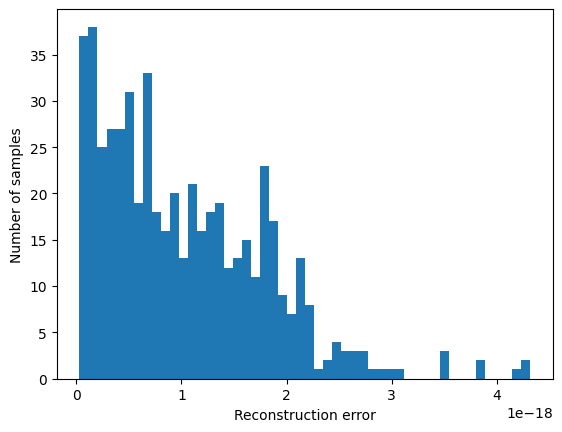

In [4]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

# Train the VAE
history = vae.fit(X_train, X_train, epochs=200, batch_size=32, validation_split=0.2, verbose=1, callbacks=[early_stopping, reduce_lr])

# Predict on the test set
X_test_pred = vae.predict(X_test)

# Calculate reconstruction error
reconstruction_loss = np.mean(np.square(X_test - X_test_pred), axis=1)

# Define a threshold for anomaly detection
threshold = np.percentile(reconstruction_loss, 95)
y_pred = (reconstruction_loss > threshold).astype(int)

# Print the classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Visualize the reconstruction error
plt.hist(reconstruction_loss, bins=50)
plt.xlabel("Reconstruction error")
plt.ylabel("Number of samples")
plt.show()


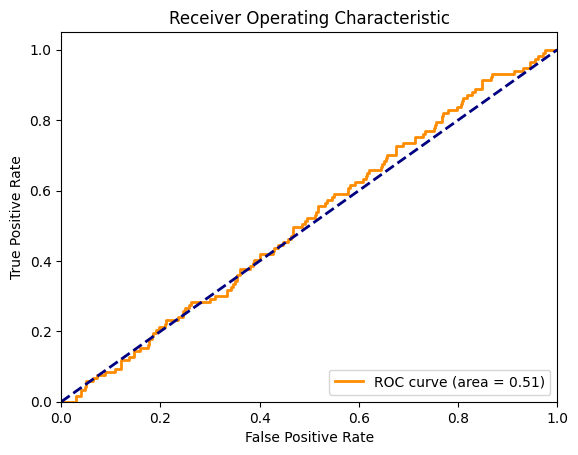


Classification Report with Optimal Threshold:
              precision    recall  f1-score   support

           0       0.85      0.15      0.26       417
           1       0.23      0.91      0.37       117

    accuracy                           0.32       534
   macro avg       0.54      0.53      0.31       534
weighted avg       0.72      0.32      0.28       534



In [5]:
from sklearn.metrics import roc_curve, auc

# Calculate reconstruction error
reconstruction_loss = np.mean(np.square(X_test - X_test_pred), axis=1)

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, reconstruction_loss)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Find optimal threshold
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

# Use the optimal threshold for anomaly detection
y_pred_optimal = (reconstruction_loss > optimal_threshold).astype(int)

# Print the classification report
print("\nClassification Report with Optimal Threshold:")
print(classification_report(y_test, y_pred_optimal))



TRYING TO IMPROVE

Epoch 1/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 24s 121ms/step - loss: 3383.2883 - val_loss: 3071.0168 - learning_rate: 0.0010
Epoch 2/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 2848.0054 - val_loss: 2781.4807 - learning_rate: 0.0010
Epoch 3/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 2772.8032 - val_loss: 2722.3127 - learning_rate: 0.0010
Epoch 4/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 2833.0449 - val_loss: 2704.2461 - learning_rate: 0.0010
Epoch 5/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 2743.3311 - val_loss: 2697.2146 - learning_rate: 0.0010
Epoch 6/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 2794.7644 - val_loss: 2694.3938 - learning_rate: 0.0010
Epoch 7/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 2786.0918 - val_loss: 2692.9346 - learning_rate: 0.0010
Epoch 8/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 2715.5476 - val_loss: 2691.6055 - learning_rate: 0.0010
Epoch 9/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 2731.7202 

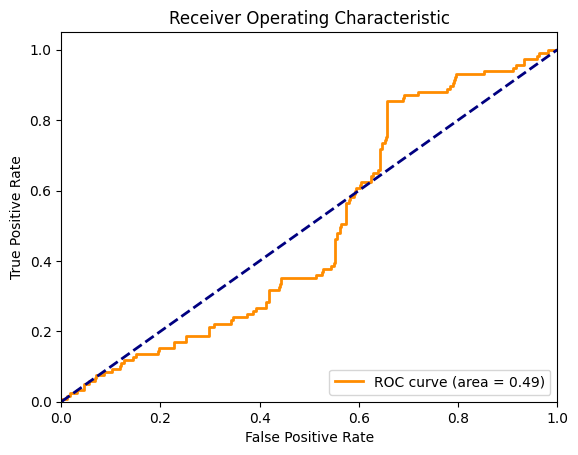

Optimal threshold: 0.009280838002116631

Classification Report with Optimal Threshold:
              precision    recall  f1-score   support

           0       0.89      0.34      0.49       417
           1       0.27      0.85      0.40       117

    accuracy                           0.45       534
   macro avg       0.58      0.59      0.45       534
weighted avg       0.75      0.45      0.47       534



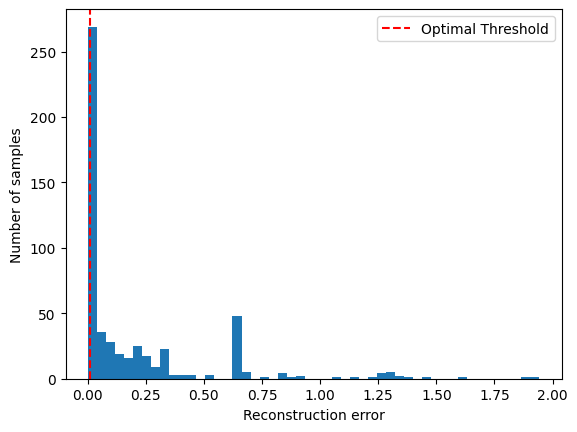

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Lambda, BatchNormalization, Activation, Dropout, Layer
from tensorflow.keras import backend as K
#from tensorflow.keras.losses import mean_squared_error
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_curve, auc
import tensorflow as tf

mse = tf.keras.losses.MeanSquaredError()

class Sampling(Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

class VAE_LossLayer(Layer):
    def __init__(self, input_dim, **kwargs):
        self.input_dim = input_dim
        super(VAE_LossLayer, self).__init__(**kwargs)


    def vae_loss(self, inputs, outputs, z_mean, z_log_var):
        reconstruction_loss = mse(inputs, outputs)
        reconstruction_loss *= self.input_dim
        kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
        kl_loss = K.sum(kl_loss, axis=-1)
        kl_loss *= -0.5
        return K.mean(reconstruction_loss + kl_loss)

    def call(self, inputs):
        inputs, outputs, z_mean, z_log_var = inputs
        loss = self.vae_loss(inputs, outputs, z_mean, z_log_var)
        self.add_loss(loss)
        return outputs

def build_vae(input_dim, latent_dim=10):
    inputs = Input(shape=(input_dim,))
    h = Dense(256)(inputs)
    h = BatchNormalization()(h)
    h = Activation('elu')(h)
    h = Dropout(0.3)(h)
    h = Dense(128)(h)
    h = BatchNormalization()(h)
    h = Activation('elu')(h)
    h = Dropout(0.3)(h)

    z_mean = Dense(latent_dim)(h)
    z_log_var = Dense(latent_dim)(h)

    z = Sampling()([z_mean, z_log_var])

    decoder_h1 = Dense(128)
    decoder_h2 = Dense(256)
    decoder_mean = Dense(input_dim, activation='sigmoid')

    h_decoded1 = decoder_h1(z)
    h_decoded1 = BatchNormalization()(h_decoded1)
    h_decoded1 = Activation('elu')(h_decoded1)
    h_decoded1 = Dropout(0.3)(h_decoded1)
    h_decoded2 = decoder_h2(h_decoded1)
    h_decoded2 = BatchNormalization()(h_decoded2)
    h_decoded2 = Activation('elu')(h_decoded2)
    h_decoded2 = Dropout(0.3)(h_decoded2)
    outputs = decoder_mean(h_decoded2)

    vae_loss_layer = VAE_LossLayer(input_dim)([inputs, outputs, z_mean, z_log_var])

    vae = Model(inputs, vae_loss_layer)
    vae.compile(optimizer='adam')
    return vae

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

input_dim = X_train_scaled.shape[1]
vae = build_vae(input_dim)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

history = vae.fit(X_train_scaled, X_train_scaled, epochs=200, batch_size=32, validation_split=0.2, verbose=1, callbacks=[early_stopping, reduce_lr])

X_test_pred = vae.predict(X_test_scaled)

reconstruction_loss = np.mean(np.square(X_test_scaled - X_test_pred), axis=1)

fpr, tpr, thresholds = roc_curve(y_test, reconstruction_loss)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal threshold: {optimal_threshold}")

y_pred_optimal = (reconstruction_loss > optimal_threshold).astype(int)

print("\nClassification Report with Optimal Threshold:")
print(classification_report(y_test, y_pred_optimal))

plt.hist(reconstruction_loss, bins=50)
plt.axvline(x=optimal_threshold, color='red', linestyle='--', label='Optimal Threshold')
plt.xlabel("Reconstruction error")
plt.ylabel("Number of samples")
plt.legend()
plt.show()

# ***TRYING WITH TRANSFER LEARNING APPROACH***

## *Perpjekja e pare*

Shape of X_1: (3425, 2455)
Shape of y_1: (3425,)
Epoch 1/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - loss: 0.4875 - val_loss: 0.0115
Epoch 2/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0107 - val_loss: 0.0064
Epoch 3/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0078 - val_loss: 0.0056
Epoch 4/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0075 - val_loss: 0.0055
Epoch 5/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0077 - val_loss: 0.0054
Epoch 6/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0073 - val_loss: 0.0051
Epoch 7/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0067 - val_loss: 0.0054
Epoch 8/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0072 - val_loss: 0.0057
Epoch 9/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0068 - val_loss: 0.0053
Epoch 10/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0068 - val_loss: 0.0057
Epoch 11/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0068 - val_loss: 0.0056
Epo

Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8             │ (None, 2455)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_35 (Dense)          │ (None, 128)            │        314,368 │ input_layer_8[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_36 (Dense)          │ (None, 64)             │          8,256 │ dense_35[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional_13             │ [(None, 2), (None, 2), │        322,884 │ input_layer_8[0][0]    │
│ (Functional)              │ (None, 2)]             │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_37 (Dense)          │ (None, 2)              │            130 │ dense_36[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_38 (Dense)          │ (None, 2)              │            130 │ dense_36[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional_14             │ (None, 2455)           │        325,207 │ functional_13[0][2]    │
│ (Functional)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ custom_variational_layer… │ (None, 2455)           │              0 │ input_layer_8[0][0],   │
│ (CustomVariationalLayer)  │                        │                │ dense_37[0][0],        │
│                           │                        │                │ dense_38[0][0],        │
│                           │                        │                │ functional_14[0][0]    │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,944,275 (7.42 MB)

 Trainable params: 648,091 (2.47 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,296,184 (4.94 MB)

Shape of X_preprocessed: (2670, 3304)
Shape of y: (2670,)
Epoch 1/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.5715 - val_loss: 0.0578
Epoch 2/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0335 - val_loss: 0.0107
Epoch 3/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0084 - val_loss: 0.0078
Epoch 4/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0073 - val_loss: 0.0074
Epoch 5/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0070 - val_loss: 0.0073
Epoch 6/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0066 - val_loss: 0.0071
Epoch 7/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0066 - val_loss: 0.0073
Epoch 8/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0062 - val_loss: 0.0074
Epoch 9/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0061 - val_loss: 0.0073
Epoch 10/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0061 - val_loss: 0.0075
Epoch 11/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0064 - val_loss: 0

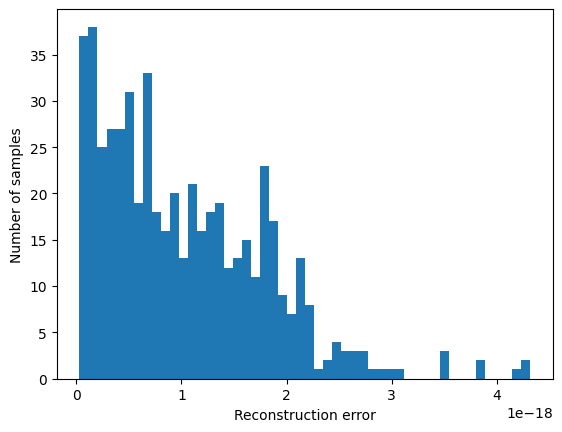

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.saving import register_keras_serializable

# Register custom layers
@register_keras_serializable(package='Custom')
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

@register_keras_serializable(package='Custom')
class CustomVariationalLayer(layers.Layer):
    def vae_loss(self, x, z_mean, z_log_var, x_decoded_mean):
        xent_loss = tf.keras.losses.binary_crossentropy(x, x_decoded_mean)
        kl_loss = - 0.5 * tf.reduce_sum(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1, axis=-1)
        return tf.reduce_mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        z_mean = inputs[1]
        z_log_var = inputs[2]
        x_decoded_mean = inputs[3]
        loss = self.vae_loss(x, z_mean, z_log_var, x_decoded_mean)
        self.add_loss(loss)
        return x

# Function to build VAE model with custom Sampling layer
def build_vae(input_shape, latent_dim):
    inputs = layers.Input(shape=(input_shape,))

    # Encoder
    x = layers.Dense(128, activation='relu')(inputs)
    x = layers.Dense(64, activation='relu')(x)
    z_mean = layers.Dense(latent_dim)(x)
    z_log_var = layers.Dense(latent_dim)(x)

    z = Sampling()([z_mean, z_log_var])

    # Decoder
    decoder_inputs = layers.Input(shape=(latent_dim,))
    x = layers.Dense(64, activation='relu')(decoder_inputs)
    x = layers.Dense(128, activation='relu')(x)
    outputs = layers.Dense(input_shape, activation='sigmoid')(x)

    encoder = models.Model(inputs, [z_mean, z_log_var, z])
    decoder = models.Model(decoder_inputs, outputs)

    vae_outputs = decoder(encoder(inputs)[2])
    vae = models.Model(inputs, vae_outputs)

    # Custom loss layer for reconstruction loss
    custom_layer = CustomVariationalLayer()([inputs, z_mean, z_log_var, vae_outputs])

    vae = models.Model(inputs, custom_layer)
    vae.compile(optimizer='adam')

    return vae, encoder, decoder

# Load and preprocess the first dataset
data_file_1 = "Book1.xlsx"
df_1 = pd.read_excel(data_file_1, sheet_name="Sheet1", header=0)

if 'CodiceTipo' in df_1.columns:
    df_1['Target'] = df_1['CodiceTipo'].apply(lambda x: 1 if x == 6 else 0)
else:
    raise ValueError("'CodiceTipo' column not found in the dataset.")

df_1.rename(columns={
    'Codice': 'idAnomalia',
    'CodiceTipo': 'note',
    'DataOraRicezione': 'dataAnomalia',
    'Latitudine': 'latitudine',
    'Longitudine': 'longitudine',
    'DataOraRilevazione': 'dataCoordinate',
    'DataOraCreazione': 'dataSegnalazione',
    'Semirimorchio': 'idConcentratore'
}, inplace=True)

datetime_columns_1 = ['dataAnomalia', 'dataCoordinate', 'dataSegnalazione']
for col in datetime_columns_1:
    df_1[col] = pd.to_datetime(df_1[col], errors='coerce')
    df_1[col] = df_1[col].astype('int64') // 10**9

for col in datetime_columns_1:
    df_1[col] = df_1[col].fillna(df_1[col].median())

df_1['Autista'] = df_1['Autista'].astype(str)
df_1['CIM'] = df_1['CIM'].astype(str)
df_1['Valore'] = df_1['Valore'].astype(str)
df_1['Anteprima'] = df_1['Anteprima'].astype(str)

numeric_features_1 = df_1.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features_1 = df_1.select_dtypes(include=['object']).columns.tolist()

if 'Target' in numeric_features_1:
    numeric_features_1.remove('Target')
if 'Target' in categorical_features_1:
    categorical_features_1.remove('Target')

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features_1),
        ('cat', categorical_transformer, categorical_features_1)
    ]
)

X_1 = preprocessor.fit_transform(df_1.drop(columns=['Target']))
y_1 = df_1['Target']

print(f"Shape of X_1: {X_1.shape}")
print(f"Shape of y_1: {y_1.shape}")

# Build and train VAE on the first dataset
input_shape = X_1.shape[1]
latent_dim = 2
vae_additional, encoder_additional, decoder_additional = build_vae(input_shape, latent_dim)

history_additional = vae_additional.fit(X_1, X_1, epochs=200, batch_size=32, validation_split=0.2, verbose=1)

print(tf.__version__)

# Print model summary before saving
vae_additional.summary()

# Save the model without save_format argument
vae_additional.save('vae_additional.h5')

# Load the model
vae_additional = tf.keras.models.load_model(
    'vae_additional.h5',
    custom_objects={'Sampling': Sampling, 'CustomVariationalLayer': CustomVariationalLayer} # Provide custom objects for the loader
)

# Load and preprocess the current dataset
data_file = "Anomalies_2021_2024.xlsx"
df = pd.read_excel(data_file, sheet_name="Sheet1", header=0)

df['Target'] = df.apply(lambda row: 1 if pd.isnull(row['idPunto']) and row['note'] in [12, 6] else 0, axis=1)
df = df.drop(columns=['idPunto', 'note'])

datetime_columns = ['dataAnomalia', 'dataCoordinate', 'dataSegnalazione']
for col in datetime_columns:
    df[col] = pd.to_datetime(df[col], errors='coerce')
    df[col] = df[col].astype('int64') // 10**9

for col in datetime_columns:
    df[col].fillna(df[col].median(), inplace=True)

categorical_features = df.select_dtypes(include=['object']).columns
df[categorical_features] = df[categorical_features].astype(str)

X = df.drop(columns=['Target'])
y = df['Target']

numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

X_preprocessed = preprocessor.fit_transform(X)

print(f"Shape of X_preprocessed: {X_preprocessed.shape}")
print(f"Shape of y: {y.shape}")

X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)

# Build and fine-tune the VAE on the current dataset
vae, encoder, decoder = build_vae(X_preprocessed.shape[1], latent_dim)

# Fine-tune the VAE on the current dataset
history = vae.fit(X_train, X_train, epochs=200, batch_size=32, validation_split=0.2, verbose=1)

# Predict on the test set
X_test_pred = vae.predict(X_test)

# Calculate reconstruction error
reconstruction_loss = np.mean(np.square(X_test - X_test_pred), axis=1)

# Define a threshold for anomaly detection
threshold = np.percentile(reconstruction_loss, 80)
y_pred = (reconstruction_loss > threshold).astype(int)

# Print the classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Visualize the reconstruction error
plt.hist(reconstruction_loss, bins=50)
plt.xlabel("Reconstruction error")
plt.ylabel("Number of samples")
plt.show()

## ***Peprjekje 2 per ta optimizuar***

1. Class imbalance handling
2. Adjusting threshold for Anomaly Detetion
3. Changed model architecture

Shape of X_1: (3425, 2455)
Shape of y_1: (3425,)
Epoch 1/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - loss: 0.4730 - val_loss: 0.0109
Epoch 2/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0110 - val_loss: 0.0059
Epoch 3/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0079 - val_loss: 0.0056
Epoch 4/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0073 - val_loss: 0.0052
Epoch 5/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0075 - val_loss: 0.0048
Epoch 6/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0076 - val_loss: 0.0057
Epoch 7/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0069 - val_loss: 0.0056
Epoch 8/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0072 - val_loss: 0.0056
Epoch 9/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0070 - val_loss: 0.0052
Epoch 10/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0070 - val_loss: 0.0060
Epoch 11/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0067 - val_loss: 0.0052
Ep

Shape of X_preprocessed: (2670, 3304)
Shape of y: (2670,)


Epoch 1/150
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.5693 - val_loss: 0.0514
Epoch 2/150
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0290 - val_loss: 0.0099
Epoch 3/150
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0088 - val_loss: 0.0076
Epoch 4/150
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0074 - val_loss: 0.0074
Epoch 5/150
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0068 - val_loss: 0.0072
Epoch 6/150
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0070 - val_loss: 0.0072
Epoch 7/150
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0068 - val_loss: 0.0074
Epoch 8/150
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0064 - val_loss: 0.0074
Epoch 9/150
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0062 - val_loss: 0.0076
Epoch 10/150
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0065 - val_loss: 0.0075
Epoch 11/150
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0061 - val_loss: 0.0075
Epoch 12/150
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step

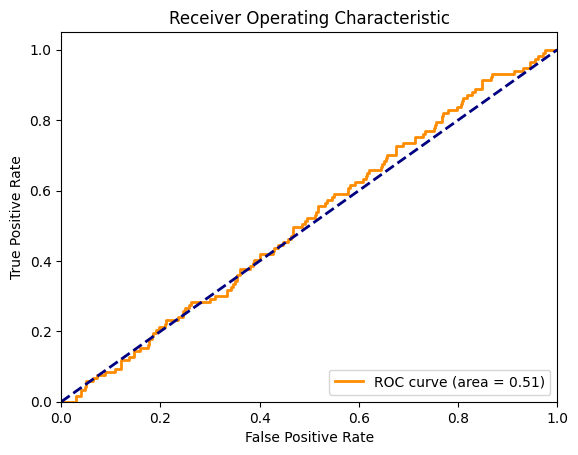


Classification Report with Optimal Threshold:
              precision    recall  f1-score   support

           0       0.85      0.15      0.26       417
           1       0.23      0.91      0.37       117

    accuracy                           0.32       534
   macro avg       0.54      0.53      0.31       534
weighted avg       0.72      0.32      0.28       534



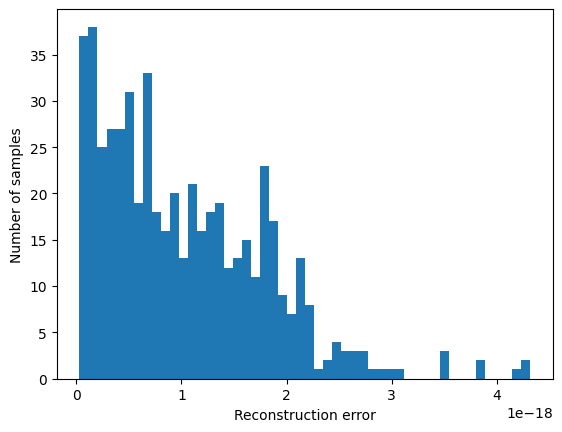

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_curve, auc
import tensorflow as tf
from tensorflow.keras import layers, models, losses

# Custom Sampling Layer
@register_keras_serializable(package='Custom')
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

@register_keras_serializable(package='Custom')
class CustomVariationalLayer(layers.Layer):
    def vae_loss(self, x, z_mean, z_log_var, x_decoded_mean):
        xent_loss = tf.keras.losses.binary_crossentropy(x, x_decoded_mean)
        kl_loss = - 0.5 * tf.reduce_sum(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1, axis=-1)
        return tf.reduce_mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        z_mean = inputs[1]
        z_log_var = inputs[2]
        x_decoded_mean = inputs[3]
        loss = self.vae_loss(x, z_mean, z_log_var, x_decoded_mean)
        self.add_loss(loss)
        return x

# Function to build VAE model with custom Sampling layer
def build_vae(input_shape, latent_dim):
    inputs = layers.Input(shape=(input_shape,))

    # Encoder
    x = layers.Dense(128, activation='relu')(inputs)
    x = layers.Dense(64, activation='relu')(x)
    z_mean = layers.Dense(latent_dim)(x)
    z_log_var = layers.Dense(latent_dim)(x)

    z = Sampling()([z_mean, z_log_var])

    # Decoder
    decoder_inputs = layers.Input(shape=(latent_dim,))
    x = layers.Dense(64, activation='relu')(decoder_inputs)
    x = layers.Dense(128, activation='relu')(x)
    outputs = layers.Dense(input_shape, activation='sigmoid')(x)

    encoder = models.Model(inputs, [z_mean, z_log_var, z])
    decoder = models.Model(decoder_inputs, outputs)

    vae_outputs = decoder(encoder(inputs)[2])
    vae = models.Model(inputs, vae_outputs)

    # Custom loss layer for reconstruction loss
    custom_layer = CustomVariationalLayer()([inputs, z_mean, z_log_var, vae_outputs])

    vae =  models.Model(inputs, custom_layer)
    vae.compile(optimizer='adam')

    return vae, encoder, decoder

# Load and preprocess the first dataset
data_file_1 = "Book1.xlsx"
df_1 = pd.read_excel(data_file_1, sheet_name="Sheet1", header=0)

if 'CodiceTipo' in df_1.columns:
    df_1['Target'] = df_1['CodiceTipo'].apply(lambda x: 1 if x == 6 else 0)
else:
    raise ValueError("'CodiceTipo' column not found in the dataset.")

df_1.rename(columns={
    'Codice': 'idAnomalia',
    'CodiceTipo': 'note',
    'DataOraRicezione': 'dataAnomalia',
    'Latitudine': 'latitudine',
    'Longitudine': 'longitudine',
    'DataOraRilevazione': 'dataCoordinate',
    'DataOraCreazione': 'dataSegnalazione',
    'Semirimorchio': 'idConcentratore'
}, inplace=True)

datetime_columns_1 = ['dataAnomalia', 'dataCoordinate', 'dataSegnalazione']
for col in datetime_columns_1:
    df_1[col] = pd.to_datetime(df_1[col], errors='coerce')
    df_1[col] = df_1[col].astype('int64') // 10**9

for col in datetime_columns_1:
    df_1[col] = df_1[col].fillna(df_1[col].median())

df_1['Autista'] = df_1['Autista'].astype(str)
df_1['CIM'] = df_1['CIM'].astype(str)
df_1['Valore'] = df_1['Valore'].astype(str)
df_1['Anteprima'] = df_1['Anteprima'].astype(str)

numeric_features_1 = df_1.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features_1 = df_1.select_dtypes(include=['object']).columns.tolist()

if 'Target' in numeric_features_1:
    numeric_features_1.remove('Target')
if 'Target' in categorical_features_1:
    categorical_features_1.remove('Target')

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features_1),
        ('cat', categorical_transformer, categorical_features_1)
    ]
)

X_1 = preprocessor.fit_transform(df_1.drop(columns=['Target']))
y_1 = df_1['Target']

print(f"Shape of X_1: {X_1.shape}")
print(f"Shape of y_1: {y_1.shape}")

# Build and train VAE on the first dataset
input_shape = X_1.shape[1]
latent_dim = 2
vae_additional, encoder_additional, decoder_additional = build_vae(input_shape, latent_dim)

history_additional = vae_additional.fit(X_1, X_1, epochs=200, batch_size=32, validation_split=0.2, verbose=1)

# Save the model using SavedModel format
vae_additional.save('vae_additional.h5')

# Load the model
vae_additional = tf.keras.models.load_model('vae_additional.h5', custom_objects={'Sampling': Sampling})

# Load and preprocess the current dataset
data_file = "Anomalies_2021_2024.xlsx"
df = pd.read_excel(data_file, sheet_name="Sheet1", header=0)

df['Target'] = df.apply(lambda row: 1 if pd.isnull(row['idPunto']) and row['note'] in [12, 6] else 0, axis=1)
df = df.drop(columns=['idPunto', 'note'])

datetime_columns = ['dataAnomalia', 'dataCoordinate', 'dataSegnalazione']
for col in datetime_columns:
    df[col] = pd.to_datetime(df[col], errors='coerce')
    df[col] = df[col].astype('int64') // 10**9

for col in datetime_columns:
    df[col].fillna(df[col].median(), inplace=True)

categorical_features = df.select_dtypes(include=['object']).columns
df[categorical_features] = df[categorical_features].astype(str)

X = df.drop(columns=['Target'])
y = df['Target']

numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

X_preprocessed = preprocessor.fit_transform(X)

print(f"Shape of X_preprocessed: {X_preprocessed.shape}")
print(f"Shape of y: {y.shape}")

X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)

# Build and fine-tune the VAE on the current dataset
vae, encoder, decoder = build_vae(X_preprocessed.shape[1], latent_dim)

# Load the additional VAE model
vae_additional = tf.keras.models.load_model('vae_additional.h5', custom_objects={'Sampling': Sampling})

# Fine-tune the VAE on the current dataset
history = vae.fit(X_train, X_train, epochs=150, batch_size=32, validation_split=0.2, verbose=1)

# Predict on the test set
X_test_pred = vae.predict(X_test)

# Calculate reconstruction error
reconstruction_loss = np.mean(np.square(X_test - X_test_pred), axis=1)

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, reconstruction_loss)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Find optimal threshold
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

# Use the optimal threshold for anomaly detection
y_pred_optimal = (reconstruction_loss > optimal_threshold).astype(int)

# Print the classification report
print("\nClassification Report with Optimal Threshold:")
print(classification_report(y_test, y_pred_optimal))

# Visualize the reconstruction error
plt.hist(reconstruction_loss, bins=50)
plt.xlabel("Reconstruction error")
plt.ylabel("Number of samples")
plt.show()


## **perpjekja 1 me ndryshim threshold dhe metrikash**

Shape of X_1: (3425, 2455)
Shape of y_1: (3425,)
Epoch 1/200
86/86 [==============================] - 3s 17ms/step - loss: 0.2518 - val_loss: 0.0110
Epoch 2/200
86/86 [==============================] - 2s 22ms/step - loss: 0.0096 - val_loss: 0.0059
Epoch 3/200
86/86 [==============================] - 2s 22ms/step - loss: 0.0078 - val_loss: 0.0053
Epoch 4/200
86/86 [==============================] - 1s 14ms/step - loss: 0.0074 - val_loss: 0.0049
Epoch 5/200
86/86 [==============================] - 1s 14ms/step - loss: 0.0072 - val_loss: 0.0059
Epoch 6/200
86/86 [==============================] - 1s 13ms/step - loss: 0.0070 - val_loss: 0.0057
Epoch 7/200
86/86 [==============================] - 1s 13ms/step - loss: 0.0070 - val_loss: 0.0057
Epoch 8/200
86/86 [==============================] - 1s 13ms/step - loss: 0.0068 - val_loss: 0.0055
Epoch 9/200
86/86 [==============================] - 1s 13ms/step - loss: 0.0068 - val_loss: 0.0056
Epoch 10/200
86/86 [==============================]

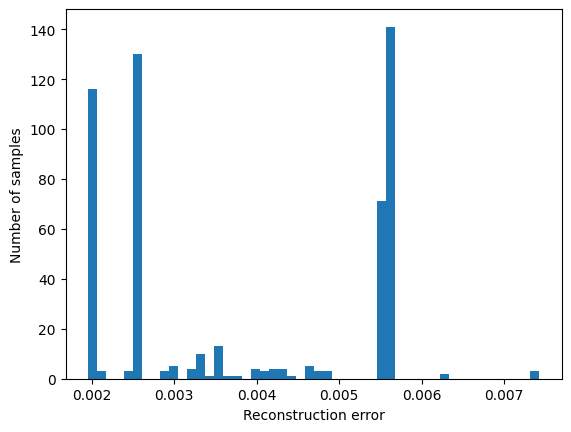

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras import layers, models, losses

# Custom Sampling Layer
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Function to build VAE model with custom Sampling layer
def build_vae(input_shape, latent_dim):
    inputs = layers.Input(shape=(input_shape,))

    # Encoder
    x = layers.Dense(128, activation='relu')(inputs)
    x = layers.Dense(64, activation='relu')(x)
    z_mean = layers.Dense(latent_dim)(x)
    z_log_var = layers.Dense(latent_dim)(x)

    z = Sampling()([z_mean, z_log_var])

    # Decoder
    decoder_inputs = layers.Input(shape=(latent_dim,))
    x = layers.Dense(64, activation='relu')(decoder_inputs)
    x = layers.Dense(128, activation='relu')(x)
    outputs = layers.Dense(input_shape, activation='sigmoid')(x)

    encoder = models.Model(inputs, [z_mean, z_log_var, z])
    decoder = models.Model(decoder_inputs, outputs)

    vae_outputs = decoder(encoder(inputs)[2])
    vae = models.Model(inputs, vae_outputs)

    reconstruction_loss = losses.binary_crossentropy(inputs, vae_outputs)
    kl_loss = -0.5 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
    vae_loss = reconstruction_loss + kl_loss
    vae.add_loss(vae_loss)
    vae.compile(optimizer='adam')

    return vae, encoder, decoder

# Load and preprocess the first dataset
data_file_1 = "Book1.xlsx"
df_1 = pd.read_excel(data_file_1, sheet_name="Sheet1", header=0)

if 'CodiceTipo' in df_1.columns:
    df_1['Target'] = df_1['CodiceTipo'].apply(lambda x: 1 if x == 6 else 0)
else:
    raise ValueError("'CodiceTipo' column not found in the dataset.")

df_1.rename(columns={
    'Codice': 'idAnomalia',
    'CodiceTipo': 'note',
    'DataOraRicezione': 'dataAnomalia',
    'Latitudine': 'latitudine',
    'Longitudine': 'longitudine',
    'DataOraRilevazione': 'dataCoordinate',
    'DataOraCreazione': 'dataSegnalazione',
    'Semirimorchio': 'idConcentratore'
}, inplace=True)

datetime_columns_1 = ['dataAnomalia', 'dataCoordinate', 'dataSegnalazione']
for col in datetime_columns_1:
    df_1[col] = pd.to_datetime(df_1[col], errors='coerce')
    df_1[col] = df_1[col].astype('int64') // 10**9

for col in datetime_columns_1:
    df_1[col] = df_1[col].fillna(df_1[col].median())

df_1['Autista'] = df_1['Autista'].astype(str)
df_1['CIM'] = df_1['CIM'].astype(str)
df_1['Valore'] = df_1['Valore'].astype(str)
df_1['Anteprima'] = df_1['Anteprima'].astype(str)

numeric_features_1 = df_1.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features_1 = df_1.select_dtypes(include=['object']).columns.tolist()

if 'Target' in numeric_features_1:
    numeric_features_1.remove('Target')
if 'Target' in categorical_features_1:
    categorical_features_1.remove('Target')

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features_1),
        ('cat', categorical_transformer, categorical_features_1)
    ]
)

X_1 = preprocessor.fit_transform(df_1.drop(columns=['Target']))
y_1 = df_1['Target']

print(f"Shape of X_1: {X_1.shape}")
print(f"Shape of y_1: {y_1.shape}")

# Build and train VAE on the first dataset
input_shape = X_1.shape[1]
latent_dim = 2
vae_additional, encoder_additional, decoder_additional = build_vae(input_shape, latent_dim)

history_additional = vae_additional.fit(X_1, X_1, epochs=200, batch_size=32, validation_split=0.2, verbose=1)

# Save the model using SavedModel format
vae_additional.save('vae_additional', save_format='tf')

# Load the model
vae_additional = tf.keras.models.load_model('vae_additional', custom_objects={'Sampling': Sampling})

# Load and preprocess the current dataset
data_file = "Anomalies_2021_2024.xlsx"
df = pd.read_excel(data_file, sheet_name="Sheet1", header=0)

df['Target'] = df.apply(lambda row: 1 if pd.isnull(row['idPunto']) and row['note'] in [12, 6] else 0, axis=1)
df = df.drop(columns=['idPunto', 'note'])

datetime_columns = ['dataAnomalia', 'dataCoordinate', 'dataSegnalazione']
for col in datetime_columns:
    df[col] = pd.to_datetime(df[col], errors='coerce')
    df[col] = df[col].astype('int64') // 10**9

for col in datetime_columns:
    df[col].fillna(df[col].median(), inplace=True)

categorical_features = df.select_dtypes(include=['object']).columns
df[categorical_features] = df[categorical_features].astype(str)

X = df.drop(columns=['Target'])
y = df['Target']

numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

X_preprocessed = preprocessor.fit_transform(X)

print(f"Shape of X_preprocessed: {X_preprocessed.shape}")
print(f"Shape of y: {y.shape}")

X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)

# Build and fine-tune the VAE on the current dataset
vae, encoder, decoder = build_vae(X_preprocessed.shape[1], latent_dim)

# Load the additional VAE model
vae_additional = tf.keras.models.load_model('vae_additional', custom_objects={'Sampling': Sampling})

# Fine-tune the VAE on the current dataset
history = vae.fit(X_train, X_train, epochs=200, batch_size=32, validation_split=0.2, verbose=1)

# Predict on the test set
X_test_pred = vae.predict(X_test)

# Calculate reconstruction error
reconstruction_loss = np.mean(np.square(X_test - X_test_pred), axis=1)

# Define a threshold for anomaly detection
threshold = np.percentile(reconstruction_loss, 70)
y_pred = (reconstruction_loss > threshold).astype(int)

# Print the classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Visualize the reconstruction error
plt.hist(reconstruction_loss, bins=50)
plt.xlabel("Reconstruction error")
plt.ylabel("Number of samples")
plt.show()


# **perpjekja 1 me ndryshim threshold dhe metrikash (updated)**

Shape of X_1: (3425, 2455)
Shape of y_1: (3425,)
Epoch 1/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 12s 83ms/step - loss: 4.4830 - val_loss: 0.4284
Epoch 2/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 11s 90ms/step - loss: 1.5853 - val_loss: 0.1497
Epoch 3/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 7s 76ms/step - loss: 1.0600 - val_loss: 0.1390
Epoch 4/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 11s 86ms/step - loss: 0.7826 - val_loss: 0.1902
Epoch 5/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - loss: 0.5519 - val_loss: 0.1017
Epoch 6/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - loss: 0.4250 - val_loss: 0.0876
Epoch 7/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - loss: 0.3477 - val_loss: 0.0476
Epoch 8/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 11s 70ms/step - loss: 0.2812 - val_loss: 0.0484
Epoch 9/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 11s 79ms/step - loss: 0.2429 - val_loss: 0.0334
Epoch 10/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 8s 92ms/step - loss: 0.1780 - val_loss: 0.0264
Epoch 11/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 7s 75ms/step - loss: 0.1519 - val_loss: 0.01

Shape of X_preprocessed: (2670, 3304)
Shape of y: (2670,)


Epoch 1/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 13s 97ms/step - loss: 4.5466 - val_loss: 1.2766
Epoch 2/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - loss: 2.0920 - val_loss: 1.1107
Epoch 3/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - loss: 1.3027 - val_loss: 0.6816
Epoch 4/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 93ms/step - loss: 0.9796 - val_loss: 0.3249
Epoch 5/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - loss: 0.7475 - val_loss: 0.1840
Epoch 6/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - loss: 0.5761 - val_loss: 0.1085
Epoch 7/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - loss: 0.4813 - val_loss: 0.0850
Epoch 8/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - loss: 0.4206 - val_loss: 0.0670
Epoch 9/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - loss: 0.3355 - val_loss: 0.0584
Epoch 10/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - loss: 0.2828 - val_loss: 0.0503
Epoch 11/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - loss: 0.2483 - val_loss: 0.0378
Epoch 12/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/ste

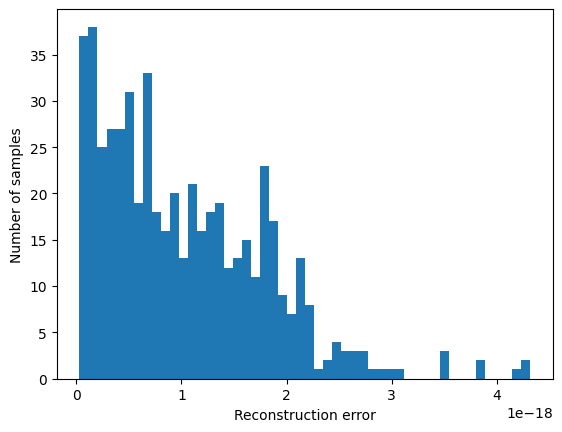

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras import layers, models, losses

@register_keras_serializable(package='Custom')
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

@register_keras_serializable(package='Custom')
class CustomVariationalLayer(layers.Layer):
    def vae_loss(self, x, z_mean, z_log_var, x_decoded_mean):
        xent_loss = tf.keras.losses.binary_crossentropy(x, x_decoded_mean)
        kl_loss = - 0.5 * tf.reduce_sum(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1, axis=-1)
        return tf.reduce_mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        z_mean = inputs[1]
        z_log_var = inputs[2]
        x_decoded_mean = inputs[3]
        loss = self.vae_loss(x, z_mean, z_log_var, x_decoded_mean)
        self.add_loss(loss)
        return x

# Function to build VAE model with custom Sampling layer
def build_vae(input_shape, latent_dim):
    inputs = layers.Input(shape=(input_shape,))

    # Encoder
    x = layers.Dense(512, activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    z_mean = layers.Dense(latent_dim)(x)
    z_log_var = layers.Dense(latent_dim)(x)

    z = Sampling()([z_mean, z_log_var])

    # Decoder
    decoder_inputs = layers.Input(shape=(latent_dim,))
    x = layers.Dense(256, activation='relu')(decoder_inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(input_shape, activation='sigmoid')(x)

    encoder = models.Model(inputs, [z_mean, z_log_var, z])
    decoder = models.Model(decoder_inputs, outputs)

    vae_outputs = decoder(encoder(inputs)[2])
    vae = models.Model(inputs, vae_outputs)

    custom_layer = CustomVariationalLayer()([inputs, z_mean, z_log_var, vae_outputs])

    vae = models.Model(inputs, custom_layer)
    vae.compile(optimizer='adam')

    return vae, encoder, decoder

# Load and preprocess the first dataset
data_file_1 = "Book1.xlsx"
df_1 = pd.read_excel(data_file_1, sheet_name="Sheet1", header=0)

if 'CodiceTipo' in df_1.columns:
    df_1['Target'] = df_1['CodiceTipo'].apply(lambda x: 1 if x == 6 else 0)
else:
    raise ValueError("'CodiceTipo' column not found in the dataset.")

df_1.rename(columns={
    'Codice': 'idAnomalia',
    'CodiceTipo': 'note',
    'DataOraRicezione': 'dataAnomalia',
    'Latitudine': 'latitudine',
    'Longitudine': 'longitudine',
    'DataOraRilevazione': 'dataCoordinate',
    'DataOraCreazione': 'dataSegnalazione',
    'Semirimorchio': 'idConcentratore'
}, inplace=True)

datetime_columns_1 = ['dataAnomalia', 'dataCoordinate', 'dataSegnalazione']
for col in datetime_columns_1:
    df_1[col] = pd.to_datetime(df_1[col], errors='coerce')
    df_1[col] = df_1[col].astype('int64') // 10**9

for col in datetime_columns_1:
    df_1[col] = df_1[col].fillna(df_1[col].median())

df_1['Autista'] = df_1['Autista'].astype(str)
df_1['CIM'] = df_1['CIM'].astype(str)
df_1['Valore'] = df_1['Valore'].astype(str)
df_1['Anteprima'] = df_1['Anteprima'].astype(str)

numeric_features_1 = df_1.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features_1 = df_1.select_dtypes(include=['object']).columns.tolist()

if 'Target' in numeric_features_1:
    numeric_features_1.remove('Target')
if 'Target' in categorical_features_1:
    categorical_features_1.remove('Target')

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features_1),
        ('cat', categorical_transformer, categorical_features_1)
    ]
)

X_1 = preprocessor.fit_transform(df_1.drop(columns=['Target']))
y_1 = df_1['Target']

print(f"Shape of X_1: {X_1.shape}")
print(f"Shape of y_1: {y_1.shape}")

# Build and train VAE on the first dataset
input_shape = X_1.shape[1]
latent_dim = 2
vae_additional, encoder_additional, decoder_additional = build_vae(input_shape, latent_dim)

history_additional = vae_additional.fit(X_1, X_1, epochs=200, batch_size=32, validation_split=0.2, verbose=1)

# Save the model using SavedModel format
vae_additional.save('vae_additional.h5')

# Load the model
vae_additional = tf.keras.models.load_model('vae_additional.h5', custom_objects={'Sampling': Sampling})

# Load and preprocess the current dataset
data_file = "Anomalies_2021_2024.xlsx"
df = pd.read_excel(data_file, sheet_name="Sheet1", header=0)

df['Target'] = df.apply(lambda row: 1 if pd.isnull(row['idPunto']) and row['note'] in [12, 6] else 0, axis=1)
df = df.drop(columns=['idPunto', 'note'])

datetime_columns = ['dataAnomalia', 'dataCoordinate', 'dataSegnalazione']
for col in datetime_columns:
    df[col] = pd.to_datetime(df[col], errors='coerce')
    df[col] = df[col].astype('int64') // 10**9

for col in datetime_columns:
    df[col].fillna(df[col].median(), inplace=True)

categorical_features = df.select_dtypes(include=['object']).columns
df[categorical_features] = df[categorical_features].astype(str)

X = df.drop(columns=['Target'])
y = df['Target']

numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

X_preprocessed = preprocessor.fit_transform(X)

print(f"Shape of X_preprocessed: {X_preprocessed.shape}")
print(f"Shape of y: {y.shape}")

X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)

# Build and fine-tune the VAE on the current dataset
vae, encoder, decoder = build_vae(X_preprocessed.shape[1], latent_dim)

# Load the additional VAE model
vae_additional = tf.keras.models.load_model('vae_additional.h5', custom_objects={'Sampling': Sampling})

# Fine-tune the VAE on the current dataset
history = vae.fit(X_train, X_train, epochs=200, batch_size=32, validation_split=0.2, verbose=1)

# Predict on the test set
X_test_pred = vae.predict(X_test)

# Calculate reconstruction error
reconstruction_loss = np.mean(np.square(X_test - X_test_pred), axis=1)

# Define a threshold for anomaly detection
threshold = np.percentile(reconstruction_loss, 70)
y_pred = (reconstruction_loss > threshold).astype(int)

# Print the classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Visualize the reconstruction error
plt.hist(reconstruction_loss, bins=50)
plt.xlabel("Reconstruction error")
plt.ylabel("Number of samples")
plt.show()


# ***Perpjekje 2 me ndryshim metricash mbase ia rrisim performancen***

Epoch 1/300
172/172 [==============================] - 6s 24ms/step - loss: 0.0911 - val_loss: 0.0062
Epoch 2/300
172/172 [==============================] - 3s 18ms/step - loss: 0.0074 - val_loss: 0.0052
Epoch 3/300
172/172 [==============================] - 3s 18ms/step - loss: 0.0072 - val_loss: 0.0052
Epoch 4/300
172/172 [==============================] - 4s 21ms/step - loss: 0.0070 - val_loss: 0.0050
Epoch 5/300
172/172 [==============================] - 4s 22ms/step - loss: 0.0068 - val_loss: 0.0057
Epoch 6/300
172/172 [==============================] - 3s 19ms/step - loss: 0.0068 - val_loss: 0.0061
Epoch 7/300
172/172 [==============================] - 3s 19ms/step - loss: 0.0066 - val_loss: 0.0056
Epoch 8/300
172/172 [==============================] - 4s 24ms/step - loss: 0.0065 - val_loss: 0.0055
Epoch 9/300
172/172 [==============================] - 4s 23ms/step - loss: 0.0065 - val_loss: 0.0054
Epoch 10/300
172/172 [==============================] - 3s 19ms/step - loss: 0.006

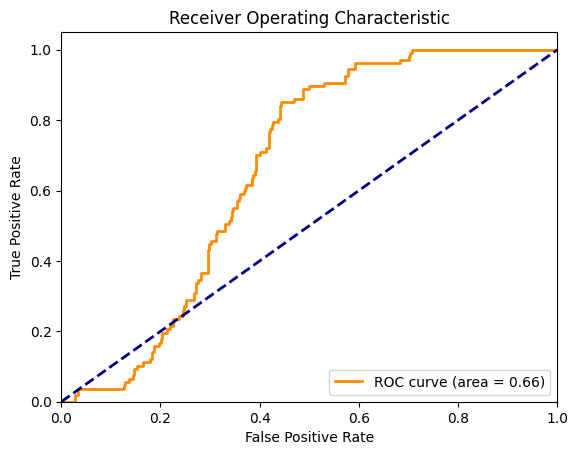


Classification Report with Optimal Threshold:
              precision    recall  f1-score   support

           0       0.93      0.56      0.70       427
           1       0.32      0.84      0.47       107

    accuracy                           0.61       534
   macro avg       0.63      0.70      0.58       534
weighted avg       0.81      0.61      0.65       534



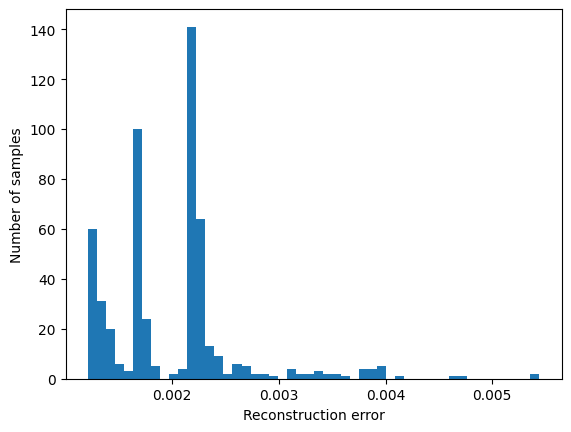

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_curve, auc, precision_recall_curve, f1_score
import tensorflow as tf
from tensorflow.keras import layers, models, losses
from tensorflow.keras.callbacks import EarlyStopping

# Custom Sampling Layer
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Function to build VAE model with custom Sampling layer
def build_vae(input_shape, latent_dim):
    inputs = layers.Input(shape=(input_shape,))

    # Encoder
    x = layers.Dense(256, activation='relu')(inputs)
    x = layers.Dense(128, activation='relu')(x)
    z_mean = layers.Dense(latent_dim)(x)
    z_log_var = layers.Dense(latent_dim)(x)

    z = Sampling()([z_mean, z_log_var])

    # Decoder
    decoder_inputs = layers.Input(shape=(latent_dim,))
    x = layers.Dense(128, activation='relu')(decoder_inputs)
    x = layers.Dense(256, activation='relu')(x)
    outputs = layers.Dense(input_shape, activation='sigmoid')(x)

    encoder = models.Model(inputs, [z_mean, z_log_var, z])
    decoder = models.Model(decoder_inputs, outputs)

    vae_outputs = decoder(encoder(inputs)[2])
    vae = models.Model(inputs, vae_outputs)

    reconstruction_loss = losses.binary_crossentropy(inputs, vae_outputs)
    kl_loss = -0.5 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
    vae_loss = reconstruction_loss + kl_loss
    vae.add_loss(vae_loss)
    vae.compile(optimizer='adam')

    return vae, encoder, decoder

# Preprocessing function
def preprocess_data(df, target_column, datetime_columns):
    df = df.copy()

    for col in datetime_columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')
        df[col] = df[col].astype('int64') // 10**9

    for col in datetime_columns:
        df[col] = df[col].fillna(df[col].median())

    categorical_features = df.select_dtypes(include=['object']).columns
    df[categorical_features] = df[categorical_features].astype(str)

    X = df.drop(columns=[target_column])
    y = df[target_column]

    numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
    categorical_features = X.select_dtypes(include=['object']).columns

    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ]
    )

    X_preprocessed = preprocessor.fit_transform(X)
    return X_preprocessed, y

# Load and preprocess the first dataset
data_file_1 = "Book1.xlsx"
df_1 = pd.read_excel(data_file_1, sheet_name="Sheet1", header=0)

if 'CodiceTipo' in df_1.columns:
    df_1['Target'] = df_1['CodiceTipo'].apply(lambda x: 1 if x == 6 else 0)
else:
    raise ValueError("'CodiceTipo' column not found in the dataset.")

df_1.rename(columns={
    'Codice': 'idAnomalia',
    'CodiceTipo': 'note',
    'DataOraRicezione': 'dataAnomalia',
    'Latitudine': 'latitudine',
    'Longitudine': 'longitudine',
    'DataOraRilevazione': 'dataCoordinate',
    'DataOraCreazione': 'dataSegnalazione',
    'Semirimorchio': 'idConcentratore'
}, inplace=True)

datetime_columns_1 = ['dataAnomalia', 'dataCoordinate', 'dataSegnalazione']

X_1, y_1 = preprocess_data(df_1, 'Target', datetime_columns_1)

# Build and train VAE on the first dataset
input_shape = X_1.shape[1]
latent_dim = 2
vae_additional, encoder_additional, decoder_additional = build_vae(input_shape, latent_dim)

history_additional = vae_additional.fit(X_1, X_1, epochs=300, batch_size=16, validation_split=0.2, verbose=1)

# Save the model using SavedModel format
vae_additional.save('vae_additional', save_format='tf')

# Load the model
vae_additional = tf.keras.models.load_model('vae_additional', custom_objects={'Sampling': Sampling})

# Load and preprocess the current dataset
data_file = "Anomalies_2021_2024.xlsx"
df = pd.read_excel(data_file, sheet_name="Sheet1", header=0)

df['Target'] = df.apply(lambda row: 1 if pd.isnull(row['idPunto']) and row['note'] in [12, 6] else 0, axis=1)
df = df.drop(columns=['idPunto', 'note'])

datetime_columns = ['dataAnomalia', 'dataCoordinate', 'dataSegnalazione']
X, y = preprocess_data(df, 'Target', datetime_columns)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build and fine-tune the VAE on the current dataset
vae, encoder, decoder = build_vae(X.shape[1], latent_dim)

# Fine-tune the VAE on the current dataset
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = vae.fit(X_train, X_train, epochs=300, batch_size=16, validation_split=0.2, verbose=1, callbacks=[early_stopping])

# Predict on the test set
X_test_pred = vae.predict(X_test)

# Calculate reconstruction error
reconstruction_loss = np.mean(np.square(X_test - X_test_pred), axis=1)

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, reconstruction_loss)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Find optimal threshold
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

# Use the optimal threshold for anomaly detection
y_pred_optimal = (reconstruction_loss > optimal_threshold).astype(int)

# Print the classification report
print("\nClassification Report with Optimal Threshold:")
print(classification_report(y_test, y_pred_optimal))

# Visualize the reconstruction error
plt.hist(reconstruction_loss, bins=50)
plt.xlabel("Reconstruction error")
plt.ylabel("Number of samples")
plt.show()


# **Ndryshim metrics part2 with updates**

Epoch 1/300
172/172 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - loss: 0.2724 - val_loss: 0.0061
Epoch 2/300
172/172 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 0.0076 - val_loss: 0.0062
Epoch 3/300
172/172 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0072 - val_loss: 0.0060
Epoch 4/300
172/172 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0070 - val_loss: 0.0060
Epoch 5/300
172/172 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.0069 - val_loss: 0.0059
Epoch 6/300
172/172 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0067 - val_loss: 0.0060
Epoch 7/300
172/172 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0066 - val_loss: 0.0061
Epoch 8/300
172/172 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0065 - val_loss: 0.0061
Epoch 9/300
172/172 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - loss: 0.0065 - val_loss: 0.0058
Epoch 10/300
172/172 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0064 - val_loss: 0.0059
Epoch 11/300
172/172 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0066 - val_loss: 0.0059
Epoch 12/300
172/172 ━━━━━━━━━

Epoch 1/300
147/147 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - loss: 0.2940 - val_loss: 0.0064
Epoch 2/300
147/147 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - loss: 0.0067 - val_loss: 0.0061
Epoch 3/300
147/147 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - loss: 0.0062 - val_loss: 0.0061
Epoch 4/300
147/147 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - loss: 0.0060 - val_loss: 0.0060
Epoch 5/300
147/147 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - loss: 0.0059 - val_loss: 0.0059
Epoch 6/300
147/147 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.0058 - val_loss: 0.0058
Epoch 7/300
147/147 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.0057 - val_loss: 0.0059
Epoch 8/300
147/147 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - loss: 0.0055 - val_loss: 0.0058
Epoch 9/300
147/147 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.0055 - val_loss: 0.0056
Epoch 10/300
147/147 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.0054 - val_loss: 0.0057
Epoch 11/300
147/147 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - loss: 0.0054 - val_loss: 0.0057
Epoch 12/300
147/147 ━━━━━━━━━

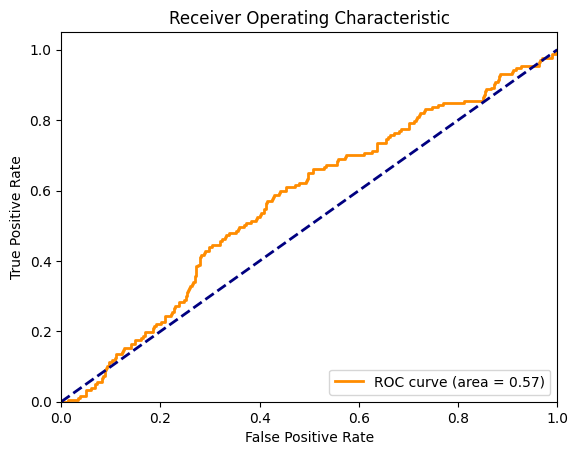


Classification Report with Optimal Threshold:
              precision    recall  f1-score   support

           0       0.81      0.57      0.67       558
           1       0.30      0.58      0.40       177

    accuracy                           0.57       735
   macro avg       0.56      0.58      0.53       735
weighted avg       0.69      0.57      0.60       735



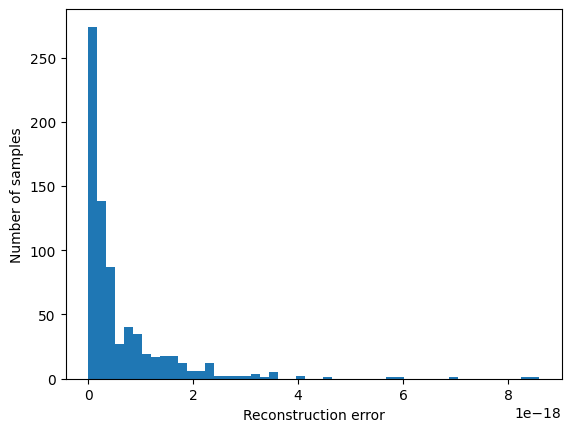

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_curve, auc, precision_recall_curve, f1_score
import tensorflow as tf
from tensorflow.keras import layers, models, losses
from tensorflow.keras.callbacks import EarlyStopping

# Custom Sampling Layer
@register_keras_serializable(package='Custom')
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

@register_keras_serializable(package='Custom')
class CustomVariationalLayer(layers.Layer):
    def vae_loss(self, x, z_mean, z_log_var, x_decoded_mean):
        xent_loss = tf.keras.losses.binary_crossentropy(x, x_decoded_mean)
        kl_loss = - 0.5 * tf.reduce_sum(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1, axis=-1)
        return tf.reduce_mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        z_mean = inputs[1]
        z_log_var = inputs[2]
        x_decoded_mean = inputs[3]
        loss = self.vae_loss(x, z_mean, z_log_var, x_decoded_mean)
        self.add_loss(loss)
        return x

# Function to build VAE model with custom Sampling layer
def build_vae(input_shape, latent_dim):
    inputs = layers.Input(shape=(input_shape,))

    # Encoder
    x = layers.Dense(256, activation='relu')(inputs)
    x = layers.Dense(128, activation='relu')(x)
    z_mean = layers.Dense(latent_dim)(x)
    z_log_var = layers.Dense(latent_dim)(x)

    z = Sampling()([z_mean, z_log_var])

    # Decoder
    decoder_inputs = layers.Input(shape=(latent_dim,))
    x = layers.Dense(128, activation='relu')(decoder_inputs)
    x = layers.Dense(256, activation='relu')(x)
    outputs = layers.Dense(input_shape, activation='sigmoid')(x)

    encoder = models.Model(inputs, [z_mean, z_log_var, z])
    decoder = models.Model(decoder_inputs, outputs)

    vae_outputs = decoder(encoder(inputs)[2])
    vae = models.Model(inputs, vae_outputs)

    custom_layer = CustomVariationalLayer()([inputs, z_mean, z_log_var, vae_outputs])

    vae = models.Model(inputs, custom_layer)
    vae.compile(optimizer='adam')

    return vae, encoder, decoder


# Preprocessing function
def preprocess_data(df, target_column, datetime_columns):
    df = df.copy()

    for col in datetime_columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')
        df[col] = df[col].astype('int64') // 10**9

    for col in datetime_columns:
        df[col] = df[col].fillna(df[col].median())

    categorical_features = df.select_dtypes(include=['object']).columns
    df[categorical_features] = df[categorical_features].astype(str)

    X = df.drop(columns=[target_column])
    y = df[target_column]

    numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
    categorical_features = X.select_dtypes(include=['object']).columns

    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ]
    )

    X_preprocessed = preprocessor.fit_transform(X)
    return X_preprocessed, y

# Load and preprocess the first dataset
data_file_1 = "Book1.xlsx"
df_1 = pd.read_excel(data_file_1, sheet_name="Sheet1", header=0)

if 'CodiceTipo' in df_1.columns:
    df_1['Target'] = df_1['CodiceTipo'].apply(lambda x: 1 if x == 6 else 0)
else:
    raise ValueError("'CodiceTipo' column not found in the dataset.")

df_1.rename(columns={
    'Codice': 'idAnomalia',
    'CodiceTipo': 'note',
    'DataOraRicezione': 'dataAnomalia',
    'Latitudine': 'latitudine',
    'Longitudine': 'longitudine',
    'DataOraRilevazione': 'dataCoordinate',
    'DataOraCreazione': 'dataSegnalazione',
    'Semirimorchio': 'idConcentratore'
}, inplace=True)

datetime_columns_1 = ['dataAnomalia', 'dataCoordinate', 'dataSegnalazione']

X_1, y_1 = preprocess_data(df_1, 'Target', datetime_columns_1)

# Build and train VAE on the first dataset
input_shape = X_1.shape[1]
latent_dim = 2
vae_additional, encoder_additional, decoder_additional = build_vae(input_shape, latent_dim)

history_additional = vae_additional.fit(X_1, X_1, epochs=300, batch_size=16, validation_split=0.2, verbose=1)

# Save the model using SavedModel format
vae_additional.save('vae_additional.h5')

# Load the model
vae_additional = tf.keras.models.load_model('vae_additional.h5', custom_objects={'Sampling': Sampling})

# Load and preprocess the current dataset
data_file = "Anomalies_2021_2024.xlsx"
df = pd.read_excel(data_file, sheet_name="Sheet1", header=0)

df['Target'] = df.apply(lambda row: 1 if pd.isnull(row['idPunto']) and row['note'] in [12, 6] else 0, axis=1)
df = df.drop(columns=['idPunto', 'note'])

datetime_columns = ['dataAnomalia', 'dataCoordinate', 'dataSegnalazione']
X, y = preprocess_data(df, 'Target', datetime_columns)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build and fine-tune the VAE on the current dataset
vae, encoder, decoder = build_vae(X.shape[1], latent_dim)

# Fine-tune the VAE on the current dataset
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = vae.fit(X_train, X_train, epochs=300, batch_size=16, validation_split=0.2, verbose=1, callbacks=[early_stopping])

# Predict on the test set
X_test_pred = vae.predict(X_test)

# Calculate reconstruction error
reconstruction_loss = np.mean(np.square(X_test - X_test_pred), axis=1)

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, reconstruction_loss)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Find optimal threshold
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

# Use the optimal threshold for anomaly detection
y_pred_optimal = (reconstruction_loss > optimal_threshold).astype(int)

# Print the classification report
print("\nClassification Report with Optimal Threshold:")
print(classification_report(y_test, y_pred_optimal))

# Visualize the reconstruction error
plt.hist(reconstruction_loss, bins=50)
plt.xlabel("Reconstruction error")
plt.ylabel("Number of samples")
plt.show()


# **Seed setting to reprodue results**

Epoch 1/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - loss: 0.4263 - val_loss: 0.0077
Epoch 2/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0086 - val_loss: 0.0063
Epoch 3/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0074 - val_loss: 0.0063
Epoch 4/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0073 - val_loss: 0.0061
Epoch 5/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0071 - val_loss: 0.0060
Epoch 6/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.0071 - val_loss: 0.0061
Epoch 7/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0069 - val_loss: 0.0060
Epoch 8/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0068 - val_loss: 0.0061
Epoch 9/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0069 - val_loss: 0.0059
Epoch 10/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 0.0066 - val_loss: 0.0061
Epoch 11/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0067 - val_loss: 0.0058
Epoch 12/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/ste

Epoch 1/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - loss: 0.5325 - val_loss: 0.0258
Epoch 2/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.0163 - val_loss: 0.0083
Epoch 3/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0083 - val_loss: 0.0074
Epoch 4/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0073 - val_loss: 0.0073
Epoch 5/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0070 - val_loss: 0.0076
Epoch 6/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0069 - val_loss: 0.0078
Epoch 7/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.0067 - val_loss: 0.0075
Epoch 8/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.0066 - val_loss: 0.0075
Epoch 9/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0066 - val_loss: 0.0078
Epoch 10/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0063 - val_loss: 0.0077
Epoch 11/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0064 - val_loss: 0.0076
Epoch 12/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step

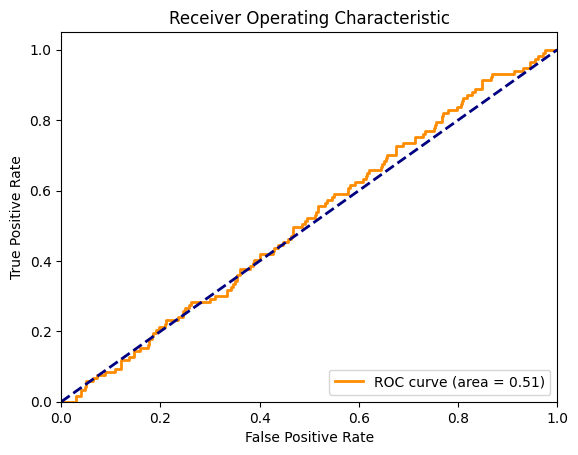


Classification Report with Optimal Threshold:
              precision    recall  f1-score   support

           0       0.85      0.15      0.26       417
           1       0.23      0.91      0.37       117

    accuracy                           0.32       534
   macro avg       0.54      0.53      0.31       534
weighted avg       0.72      0.32      0.28       534



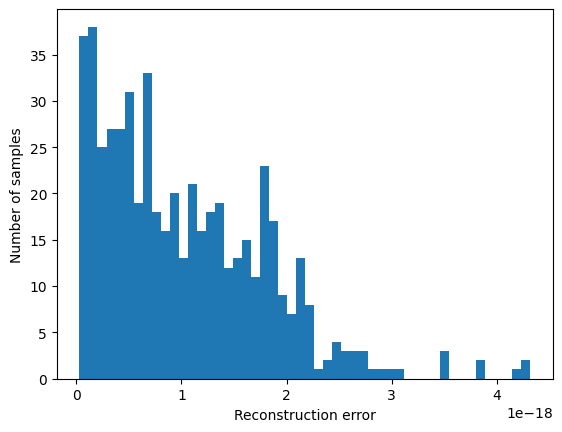

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_curve, auc, precision_recall_curve, f1_score
import tensorflow as tf
from tensorflow.keras import layers, models, losses
from tensorflow.keras.callbacks import EarlyStopping
import random

# Set random seeds for reproducibility
def set_seeds(seed=42):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    random.seed(seed)

set_seeds()

# Register custom layers
@register_keras_serializable(package='Custom')
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

@register_keras_serializable(package='Custom')
class CustomVariationalLayer(layers.Layer):
    def vae_loss(self, x, z_mean, z_log_var, x_decoded_mean):
        xent_loss = tf.keras.losses.binary_crossentropy(x, x_decoded_mean)
        kl_loss = - 0.5 * tf.reduce_sum(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1, axis=-1)
        return tf.reduce_mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        z_mean = inputs[1]
        z_log_var = inputs[2]
        x_decoded_mean = inputs[3]
        loss = self.vae_loss(x, z_mean, z_log_var, x_decoded_mean)
        self.add_loss(loss)
        return x

# Function to build VAE model with custom Sampling layer
def build_vae(input_shape, latent_dim):
    inputs = layers.Input(shape=(input_shape,))

    # Encoder
    x = layers.Dense(256, activation='relu')(inputs)
    x = layers.Dense(64, activation='relu')(x)
    z_mean = layers.Dense(latent_dim)(x)
    z_log_var = layers.Dense(latent_dim)(x)

    z = Sampling()([z_mean, z_log_var])

    # Decoder
    decoder_inputs = layers.Input(shape=(latent_dim,))
    x = layers.Dense(64, activation='relu')(decoder_inputs)
    x = layers.Dense(256, activation='relu')(x)
    outputs = layers.Dense(input_shape, activation='sigmoid')(x)

    encoder = models.Model(inputs, [z_mean, z_log_var, z])
    decoder = models.Model(decoder_inputs, outputs)

    vae_outputs = decoder(encoder(inputs)[2])
    vae = models.Model(inputs, vae_outputs)

   # reconstruction_loss = losses.binary_crossentropy(inputs, vae_outputs)
   # kl_loss = -0.5 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
   # vae_loss = reconstruction_loss + kl_loss
   # vae.add_loss(vae_loss)
   # vae.compile(optimizer='adam')

    custom_layer = CustomVariationalLayer()([inputs, z_mean, z_log_var, vae_outputs])

    vae = models.Model(inputs, custom_layer)
    vae.compile(optimizer='adam')

    return vae, encoder, decoder

# Preprocessing function
def preprocess_data(df, target_column, datetime_columns):
    df = df.copy()

    for col in datetime_columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')
        df[col] = df[col].astype('int64') // 10**9

    for col in datetime_columns:
        df[col] = df[col].fillna(df[col].median())

    categorical_features = df.select_dtypes(include=['object']).columns
    df[categorical_features] = df[categorical_features].astype(str)

    X = df.drop(columns=[target_column])
    y = df[target_column]

    numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
    categorical_features = X.select_dtypes(include=['object']).columns

    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ]
    )

    X_preprocessed = preprocessor.fit_transform(X)
    return X_preprocessed, y

# Load and preprocess the first dataset
data_file_1 = "Book1.xlsx"
df_1 = pd.read_excel(data_file_1, sheet_name="Sheet1", header=0)

if 'CodiceTipo' in df_1.columns:
    df_1['Target'] = df_1['CodiceTipo'].apply(lambda x: 1 if x == 6 else 0)
else:
    raise ValueError("'CodiceTipo' column not found in the dataset.")

df_1.rename(columns={
    'Codice': 'idAnomalia',
    'CodiceTipo': 'note',
    'DataOraRicezione': 'dataAnomalia',
    'Latitudine': 'latitudine',
    'Longitudine': 'longitudine',
    'DataOraRilevazione': 'dataCoordinate',
    'DataOraCreazione': 'dataSegnalazione',
    'Semirimorchio': 'idConcentratore'
}, inplace=True)

datetime_columns_1 = ['dataAnomalia', 'dataCoordinate', 'dataSegnalazione']

X_1, y_1 = preprocess_data(df_1, 'Target', datetime_columns_1)

# Build and train VAE on the first dataset
input_shape = X_1.shape[1]
latent_dim = 20
vae_additional, encoder_additional, decoder_additional = build_vae(input_shape, latent_dim)

history_additional = vae_additional.fit(X_1, X_1, epochs=200, batch_size=32, validation_split=0.2, verbose=1)

# Save the model using SavedModel format
vae_additional.save('vae_additional.h5')

# Load the model
vae_additional = tf.keras.models.load_model('vae_additional.h5', custom_objects={'Sampling': Sampling})

# Load and preprocess the current dataset
data_file = "Anomalies_2021_2024.xlsx"
df = pd.read_excel(data_file, sheet_name="Sheet1", header=0)

df['Target'] = df.apply(lambda row: 1 if pd.isnull(row['idPunto']) and row['note'] in [12, 6] else 0, axis=1)
df = df.drop(columns=['idPunto', 'note'])

datetime_columns = ['dataAnomalia', 'dataCoordinate', 'dataSegnalazione']
X, y = preprocess_data(df, 'Target', datetime_columns)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build and fine-tune the VAE on the current dataset
vae, encoder, decoder = build_vae(X.shape[1], latent_dim)

# Fine-tune the VAE on the current dataset
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = vae.fit(X_train, X_train, epochs=200, batch_size=32, validation_split=0.2, verbose=1, callbacks=[early_stopping])

# Predict on the test set
X_test_pred = vae.predict(X_test)

# Calculate reconstruction error
reconstruction_loss = np.mean(np.square(X_test - X_test_pred), axis=1)

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, reconstruction_loss)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Find optimal threshold
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

# Use the optimal threshold for anomaly detection
y_pred_optimal = (reconstruction_loss > optimal_threshold).astype(int)

# Print the classification report
print("\nClassification Report with Optimal Threshold:")
print(classification_report(y_test, y_pred_optimal))

# Visualize the reconstruction error
plt.hist(reconstruction_loss, bins=50)
plt.xlabel("Reconstruction error")
plt.ylabel("Number of samples")
plt.show()


# **Including MinMax Scaler**

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, roc_curve, auc

# Adjust the preprocessing function to include MinMaxScaler
def preprocess_data(df, target_column, datetime_columns):
    df = df.copy()

    for col in datetime_columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')
        df[col] = df[col].astype('int64') // 10**9
    df.fillna(df.median(), inplace=True)

    categorical_features = df.select_dtypes(include=['object']).columns
    df[categorical_features] = df[categorical_features].astype(str)

    X = df.drop(columns=[target_column])
    y = df[target_column]

    numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
    categorical_features = X.select_dtypes(include=['object']).columns

    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', MinMaxScaler())  # Changed to MinMaxScaler
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ]
    )

    X_preprocessed = preprocessor.fit_transform(X)
    return X_preprocessed, y

# After tuning the VAE or trying different models
# Use GridSearchCV or manual tuning for hyperparameters
# Example: grid search for VAE latent dimension
from sklearn.model_selection import ParameterGrid

param_grid = {'latent_dim': [2, 4, 8]}
best_auc = 0
best_latent_dim = None

for params in ParameterGrid(param_grid):
    latent_dim = params['latent_dim']
    vae, encoder, decoder = build_vae(X.shape[1], latent_dim)
    history = vae.fit(X_train, X_train, epochs=150, batch_size=32, validation_split=0.2, verbose=1, callbacks=[early_stopping])
    X_test_pred = vae.predict(X_test)
    reconstruction_loss = np.mean(np.square(X_test - X_test_pred), axis=1)
    fpr, tpr, thresholds = roc_curve(y_test, reconstruction_loss)
    roc_auc = auc(fpr, tpr)

    if roc_auc > best_auc:
        best_auc = roc_auc
        best_latent_dim = latent_dim

print(f"Best Latent Dimension: {best_latent_dim}, AUC: {best_auc}")


Epoch 1/150
54/54 [==============================] - 3s 22ms/step - loss: 0.3694 - val_loss: 0.0465
Epoch 2/150
54/54 [==============================] - 1s 20ms/step - loss: 0.0183 - val_loss: 0.0095
Epoch 3/150
54/54 [==============================] - 1s 27ms/step - loss: 0.0082 - val_loss: 0.0080
Epoch 4/150
54/54 [==============================] - 1s 28ms/step - loss: 0.0072 - val_loss: 0.0076
Epoch 5/150
54/54 [==============================] - 1s 20ms/step - loss: 0.0068 - val_loss: 0.0073
Epoch 6/150
54/54 [==============================] - 1s 17ms/step - loss: 0.0065 - val_loss: 0.0076
Epoch 7/150
54/54 [==============================] - 1s 16ms/step - loss: 0.0066 - val_loss: 0.0077
Epoch 8/150
54/54 [==============================] - 1s 19ms/step - loss: 0.0064 - val_loss: 0.0074
Epoch 9/150
54/54 [==============================] - 1s 18ms/step - loss: 0.0064 - val_loss: 0.0075
Epoch 10/150
54/54 [==============================] - 1s 18ms/step - loss: 0.0064 - val_loss: 0.0080

Epoch 1/400
172/172 [==============================] - 4s 12ms/step - loss: 0.1391 - val_loss: 0.0068
Epoch 2/400
172/172 [==============================] - 2s 11ms/step - loss: 0.0075 - val_loss: 0.0053
Epoch 3/400
172/172 [==============================] - 2s 14ms/step - loss: 0.0071 - val_loss: 0.0050
Epoch 4/400
172/172 [==============================] - 3s 18ms/step - loss: 0.0070 - val_loss: 0.0048
Epoch 5/400
172/172 [==============================] - 2s 11ms/step - loss: 0.0068 - val_loss: 0.0054
Epoch 6/400
172/172 [==============================] - 2s 11ms/step - loss: 0.0068 - val_loss: 0.0060
Epoch 7/400
172/172 [==============================] - 2s 11ms/step - loss: 0.0067 - val_loss: 0.0054
Epoch 8/400
172/172 [==============================] - 2s 11ms/step - loss: 0.0065 - val_loss: 0.0055
Epoch 9/400
172/172 [==============================] - 2s 11ms/step - loss: 0.0065 - val_loss: 0.0054
Epoch 10/400
172/172 [==============================] - 3s 17ms/step - loss: 0.006

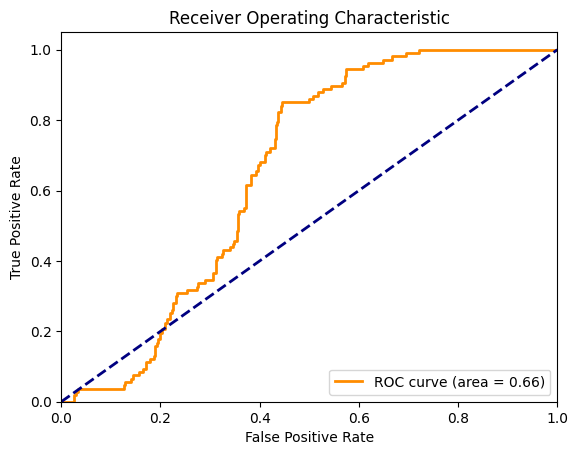


Classification Report with Optimal Threshold:
              precision    recall  f1-score   support

           0       0.93      0.56      0.70       427
           1       0.32      0.84      0.47       107

    accuracy                           0.61       534
   macro avg       0.63      0.70      0.58       534
weighted avg       0.81      0.61      0.65       534



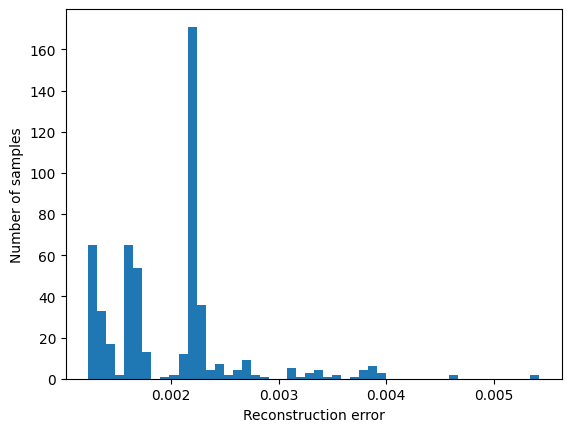

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import tensorflow as tf
from tensorflow.keras import layers, models, losses
from tensorflow.keras.callbacks import EarlyStopping
import random

# Set random seeds for reproducibility
def set_seeds(seed=42):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    random.seed(seed)

set_seeds()

# Custom Sampling Layer
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Function to build VAE model with custom Sampling layer
def build_vae(input_shape, latent_dim):
    inputs = layers.Input(shape=(input_shape,))

    # Encoder
    x = layers.Dense(128, activation='relu')(inputs)
    x = layers.Dense(128, activation='relu')(x)
    z_mean = layers.Dense(latent_dim)(x)
    z_log_var = layers.Dense(latent_dim)(x)

    z = Sampling()([z_mean, z_log_var])

    # Decoder
    decoder_inputs = layers.Input(shape=(latent_dim,))
    x = layers.Dense(64, activation='relu')(decoder_inputs)
    x = layers.Dense(128, activation='relu')(x)
    outputs = layers.Dense(input_shape, activation='sigmoid')(x)

    encoder = models.Model(inputs, [z_mean, z_log_var, z])
    decoder = models.Model(decoder_inputs, outputs)

    vae_outputs = decoder(encoder(inputs)[2])
    vae = models.Model(inputs, vae_outputs)

    reconstruction_loss = losses.binary_crossentropy(inputs, vae_outputs)
    kl_loss = -0.5 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
    vae_loss = reconstruction_loss + kl_loss
    vae.add_loss(vae_loss)
    vae.compile(optimizer='adam')

    return vae, encoder, decoder

# Preprocessing function
def preprocess_data(df, target_column, datetime_columns):
    df = df.copy()

    for col in datetime_columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')
        df[col] = df[col].astype('int64') // 10**9

    for col in datetime_columns:
        df[col] = df[col].fillna(df[col].median())

    categorical_features = df.select_dtypes(include=['object']).columns
    df[categorical_features] = df[categorical_features].astype(str)

    X = df.drop(columns=[target_column])
    y = df[target_column]

    numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
    categorical_features = X.select_dtypes(include=['object']).columns

    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ]
    )

    X_preprocessed = preprocessor.fit_transform(X)
    return X_preprocessed, y

# Load and preprocess the first dataset
data_file_1 = "Book1.xlsx"
df_1 = pd.read_excel(data_file_1, sheet_name="Sheet1", header=0)

if 'CodiceTipo' in df_1.columns:
    df_1['Target'] = df_1['CodiceTipo'].apply(lambda x: 1 if x == 6 else 0)
else:
    raise ValueError("'CodiceTipo' column not found in the dataset.")

df_1.rename(columns={
    'Codice': 'idAnomalia',
    'CodiceTipo': 'note',
    'DataOraRicezione': 'dataAnomalia',
    'Latitudine': 'latitudine',
    'Longitudine': 'longitudine',
    'DataOraRilevazione': 'dataCoordinate',
    'DataOraCreazione': 'dataSegnalazione',
    'Semirimorchio': 'idConcentratore'
}, inplace=True)

datetime_columns_1 = ['dataAnomalia', 'dataCoordinate', 'dataSegnalazione']

X_1, y_1 = preprocess_data(df_1, 'Target', datetime_columns_1)

# Build and train VAE on the first dataset
input_shape = X_1.shape[1]
latent_dim = 2
vae_additional, encoder_additional, decoder_additional = build_vae(input_shape, latent_dim)

history_additional = vae_additional.fit(X_1, X_1, epochs=400, batch_size=16, validation_split=0.2, verbose=1)

# Save the model using SavedModel format
vae_additional.save('vae_additional', save_format='tf')

# Load the model
vae_additional = tf.keras.models.load_model('vae_additional', custom_objects={'Sampling': Sampling})

# Load and preprocess the current dataset
data_file = "Anomalies_2021_2024.xlsx"
df = pd.read_excel(data_file, sheet_name="Sheet1", header=0)

df['Target'] = df.apply(lambda row: 1 if pd.isnull(row['idPunto']) and row['note'] in [12, 6] else 0, axis=1)
df = df.drop(columns=['idPunto', 'note'])

datetime_columns = ['dataAnomalia', 'dataCoordinate', 'dataSegnalazione']
X, y = preprocess_data(df, 'Target', datetime_columns)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build and fine-tune the VAE on the current dataset
vae, encoder, decoder = build_vae(X.shape[1], latent_dim)

# Fine-tune the VAE on the current dataset
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = vae.fit(X_train, X_train, epochs=400, batch_size=16, validation_split=0.2, verbose=1, callbacks=[early_stopping])

# Predict on the test set
X_test_pred = vae.predict(X_test)

# Calculate reconstruction error
reconstruction_loss = np.mean(np.square(X_test - X_test_pred), axis=1)

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, reconstruction_loss)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Find optimal threshold
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

# Use the optimal threshold for anomaly detection
y_pred_optimal = (reconstruction_loss > optimal_threshold).astype(int)

# Print the classification report
print("\nClassification Report with Optimal Threshold:")
print(classification_report(y_test, y_pred_optimal))

# Visualize the reconstruction error
plt.hist(reconstruction_loss, bins=50)
plt.xlabel("Reconstruction error")
plt.ylabel("Number of samples")
plt.show()


# **Using SMOTE and Increasing Complexity of the neural network**

Epoch 1/200
86/86 [==============================] - 4s 26ms/step - loss: 0.1511 - val_loss: 0.0074
Epoch 2/200
86/86 [==============================] - 2s 27ms/step - loss: 0.0082 - val_loss: 0.0064
Epoch 3/200
86/86 [==============================] - 3s 39ms/step - loss: 0.0078 - val_loss: 0.0060
Epoch 4/200
86/86 [==============================] - 2s 23ms/step - loss: 0.0075 - val_loss: 0.0055
Epoch 5/200
86/86 [==============================] - 2s 23ms/step - loss: 0.0071 - val_loss: 0.0057
Epoch 6/200
86/86 [==============================] - 2s 23ms/step - loss: 0.0069 - val_loss: 0.0062
Epoch 7/200
86/86 [==============================] - 2s 25ms/step - loss: 0.0066 - val_loss: 0.0055
Epoch 8/200
86/86 [==============================] - 2s 25ms/step - loss: 0.0065 - val_loss: 0.0056
Epoch 9/200
86/86 [==============================] - 3s 38ms/step - loss: 0.0063 - val_loss: 0.0051
Epoch 10/200
86/86 [==============================] - 2s 24ms/step - loss: 0.0063 - val_loss: 0.0062

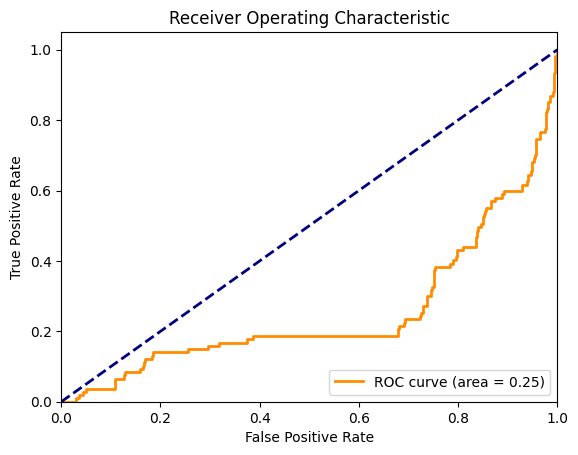


Classification Report with Optimal Threshold:
              precision    recall  f1-score   support

           0       0.80      1.00      0.89       427
           1       0.00      0.00      0.00       107

    accuracy                           0.80       534
   macro avg       0.40      0.50      0.44       534
weighted avg       0.64      0.80      0.71       534



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


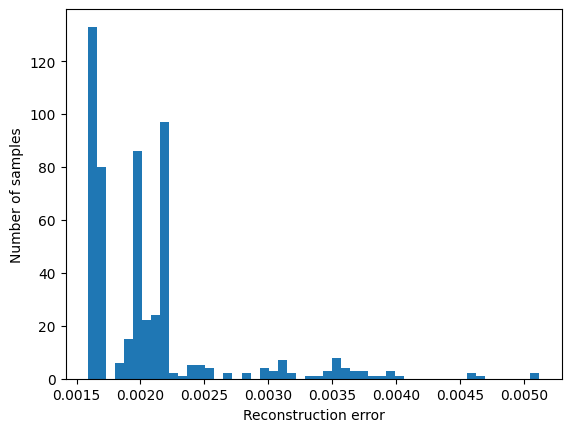

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_curve, auc, precision_recall_curve, f1_score
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras import layers, models, losses
from tensorflow.keras.callbacks import EarlyStopping
import random

# Set random seeds for reproducibility
def set_seeds(seed=42):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    random.seed(seed)

set_seeds()

# Custom Sampling Layer
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Function to build VAE model with increased complexity
def build_vae(input_shape, latent_dim):
    inputs = layers.Input(shape=(input_shape,))

    # Encoder with increased complexity
    x = layers.Dense(256, activation='relu')(inputs)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(64, activation='relu')(x)
    z_mean = layers.Dense(latent_dim)(x)
    z_log_var = layers.Dense(latent_dim)(x)

    z = Sampling()([z_mean, z_log_var])

    # Decoder with increased complexity
    decoder_inputs = layers.Input(shape=(latent_dim,))
    x = layers.Dense(64, activation='relu')(decoder_inputs)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(256, activation='relu')(x)
    outputs = layers.Dense(input_shape, activation='sigmoid')(x)

    encoder = models.Model(inputs, [z_mean, z_log_var, z])
    decoder = models.Model(decoder_inputs, outputs)

    vae_outputs = decoder(encoder(inputs)[2])
    vae = models.Model(inputs, vae_outputs)

    reconstruction_loss = losses.binary_crossentropy(inputs, vae_outputs)
    kl_loss = -0.5 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
    vae_loss = reconstruction_loss + kl_loss
    vae.add_loss(vae_loss)
    vae.compile(optimizer='adam')

    return vae, encoder, decoder

# Preprocessing function
def preprocess_data(df, target_column, datetime_columns):
    df = df.copy()

    for col in datetime_columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')
        df[col] = df[col].astype('int64') // 10**9

    for col in datetime_columns:
        df[col] = df[col].fillna(df[col].median())

    categorical_features = df.select_dtypes(include=['object']).columns
    df[categorical_features] = df[categorical_features].astype(str)

    X = df.drop(columns=[target_column])
    y = df[target_column]

    numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
    categorical_features = X.select_dtypes(include=['object']).columns

    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ]
    )

    X_preprocessed = preprocessor.fit_transform(X)
    return X_preprocessed, y

# Load and preprocess the first dataset
data_file_1 = "Book1.xlsx"
df_1 = pd.read_excel(data_file_1, sheet_name="Sheet1", header=0)

if 'CodiceTipo' in df_1.columns:
    df_1['Target'] = df_1['CodiceTipo'].apply(lambda x: 1 if x == 6 else 0)
else:
    raise ValueError("'CodiceTipo' column not found in the dataset.")

df_1.rename(columns={
    'Codice': 'idAnomalia',
    'CodiceTipo': 'note',
    'DataOraRicezione': 'dataAnomalia',
    'Latitudine': 'latitudine',
    'Longitudine': 'longitudine',
    'DataOraRilevazione': 'dataCoordinate',
    'DataOraCreazione': 'dataSegnalazione',
    'Semirimorchio': 'idConcentratore'
}, inplace=True)

datetime_columns_1 = ['dataAnomalia', 'dataCoordinate', 'dataSegnalazione']

X_1, y_1 = preprocess_data(df_1, 'Target', datetime_columns_1)

# Build and train VAE on the first dataset
input_shape = X_1.shape[1]
latent_dim = 2
vae_additional, encoder_additional, decoder_additional = build_vae(input_shape, latent_dim)

history_additional = vae_additional.fit(X_1, X_1, epochs=200, batch_size=32, validation_split=0.2, verbose=1)

# Save the model using SavedModel format
vae_additional.save('vae_additional', save_format='tf')

# Load the model
vae_additional = tf.keras.models.load_model('vae_additional', custom_objects={'Sampling': Sampling})

# Load and preprocess the current dataset
data_file = "Anomalies_2021_2024.xlsx"
df = pd.read_excel(data_file, sheet_name="Sheet1", header=0)

df['Target'] = df.apply(lambda row: 1 if pd.isnull(row['idPunto']) and row['note'] in [12, 6] else 0, axis=1)
df = df.drop(columns=['idPunto', 'note'])

datetime_columns = ['dataAnomalia', 'dataCoordinate', 'dataSegnalazione']
X, y = preprocess_data(df, 'Target', datetime_columns)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Build and fine-tune the VAE on the current dataset with increased complexity
vae, encoder, decoder = build_vae(X.shape[1], latent_dim)

# Fine-tune the VAE on the resampled data
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = vae.fit(X_train_resampled, X_train_resampled, epochs=200, batch_size=32, validation_split=0.2, verbose=1, callbacks=[early_stopping])

# Predict on the test set
X_test_pred = vae.predict(X_test)

# Calculate reconstruction error
reconstruction_loss = np.mean(np.square(X_test - X_test_pred), axis=1)

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, reconstruction_loss)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Find optimal threshold
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

# Use the optimal threshold for anomaly detection
y_pred_optimal = (reconstruction_loss > optimal_threshold).astype(int)

# Print the classification report
print("\nClassification Report with Optimal Threshold:")
print(classification_report(y_test, y_pred_optimal))

# Visualize the reconstruction error
plt.hist(reconstruction_loss, bins=50)
plt.xlabel("Reconstruction error")
plt.ylabel("Number of samples")
plt.show()
